# Pipeline for CNN with P300 data

## Environment
conda create -n P300_pipeline python=3.11 \
conda activate P300_pipeline

## Packages

pip install \
  "numpy<2" \
  "moabb<1.4" \
  "pyriemann<0.9" \
  braindecode \
  mne \
  scipy \
  pandas \
  scikit-learn\
  optuna


python -m pip install -U ipykernel\
python -m ipykernel install --user --name P300_pipeline --display-name "Python (P300_pipeline)"


## Dataset (one subject)

In [1]:
from braindecode.datasets import MOABBDataset

# all subjects (BNCI2014_009 has 10 subjects)
dataset_full = MOABBDataset(dataset_name="BNCI2014_009")

print("Number of recordings:", len(dataset_full.datasets))
print(dataset_full.description.head())
print(dataset_full.description.columns)


/opt/anaconda3/envs/P300_pipeline/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of recordings: 30
   subject session run
0        1       0   0
1        1       1   0
2        1       2   0
3        2       0   0
4        2       1   0
Index(['subject', 'session', 'run'], dtype='object')


In [2]:
from braindecode.datasets import MOABBDataset

subject_id = 1
dataset = MOABBDataset(dataset_name="BNCI2014_009", subject_ids=[subject_id])

### Inspect dataset

In [4]:
# see subjects and their sessions
import pandas as pd
pd.set_option("display.max_columns", None)

dataset_full.description.groupby("subject").size()

subject
1     3
2     3
3     3
4     3
5     3
6     3
7     3
8     3
9     3
10    3
dtype: int64

In [5]:
# One subject → one or more MNE Raw objects
raw = dataset.datasets[0].raw

print(raw)

# Channel names
print(raw.ch_names)

# Channel types (EEG, stim, etc.)
print(raw.get_channel_types())


<RawArray | 18 x 50184 (196.0 s), ~6.9 MiB, data loaded>
['Fz', 'Cz', 'Pz', 'Oz', 'P3', 'P4', 'PO7', 'PO8', 'F3', 'F4', 'FCz', 'C3', 'C4', 'CP3', 'CPz', 'CP4', 'Target stim', 'Flash stim']
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'stim', 'stim']


In [6]:
import mne
#  Number of channels
print("n_channels:", raw.info["nchan"])

# Sampling frequency
print("sfreq:", raw.info["sfreq"])

# Pick only EEG channels
eeg_picks = mne.pick_types(raw.info, eeg=True, stim=False)
print("EEG channel indices:", eeg_picks)
print("EEG channel names:", [raw.ch_names[i] for i in eeg_picks])


n_channels: 18
sfreq: 256.0
EEG channel indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
EEG channel names: ['Fz', 'Cz', 'Pz', 'Oz', 'P3', 'P4', 'PO7', 'PO8', 'F3', 'F4', 'FCz', 'C3', 'C4', 'CP3', 'CPz', 'CP4']


In [7]:
# Get EEG data as numpy array (shape: n_channels x n_samples))
data = raw.get_data(picks="eeg")

print("EEG data shape:", data.shape)


EEG data shape: (16, 50184)


In [8]:
# check events and labels 
events, event_id = mne.events_from_annotations(raw)

print("Event IDs:", event_id)
print("First 10 events:\n", events[:10])

Used Annotations descriptions: ['NonTarget', 'Target']
Event IDs: {'NonTarget': 1, 'Target': 2}
First 10 events:
 [[1544    0    1]
 [1608    0    1]
 [1672    0    2]
 [1736    0    1]
 [1800    0    1]
 [1864    0    1]
 [1928    0    1]
 [1992    0    1]
 [2056    0    2]
 [2120    0    1]]


Using matplotlib as 2D backend.


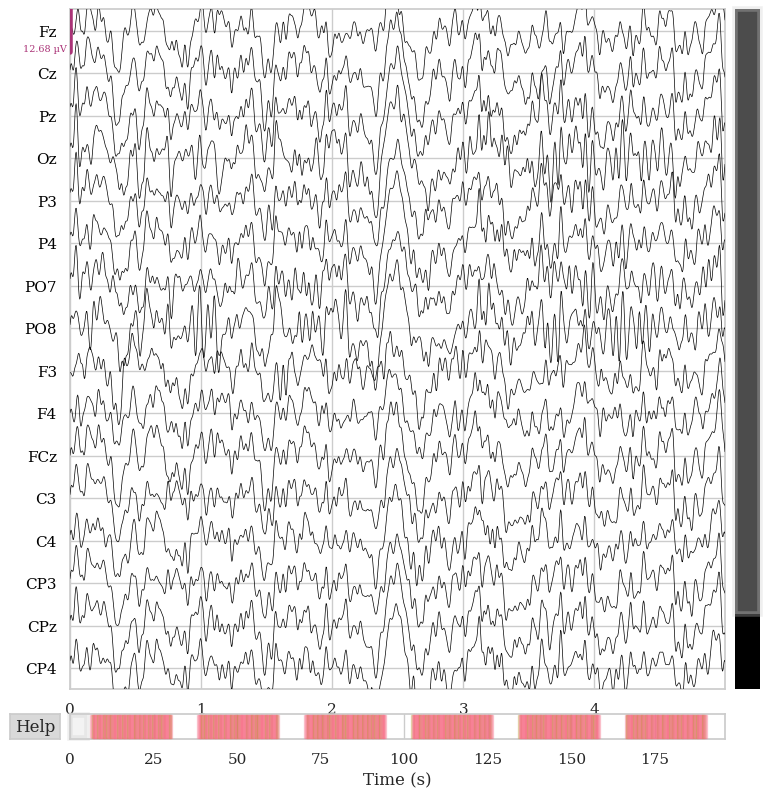

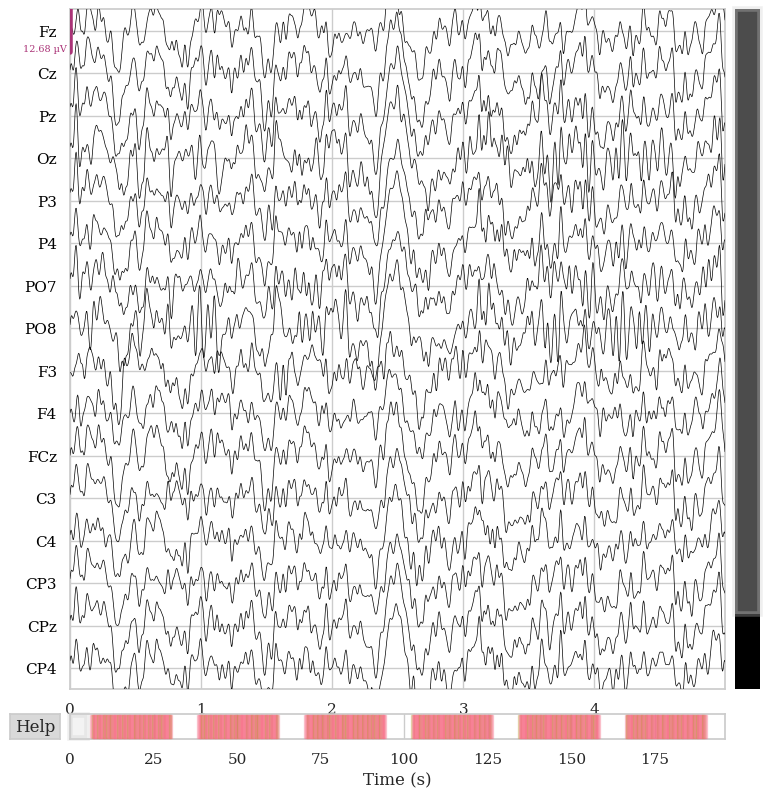

In [9]:
# Plot a few seconds of EEG
raw.plot(n_channels=16, duration=5, scalings="auto")


## Dataset (1 subject, 8 channels)

In [ ]:
from braindecode.datasets import MOABBDataset

# all subjects (BNCI2014_009 has 10 subjects)
dataset_full = MOABBDataset(dataset_name="BNCI2014_009")

print("Number of recordings:", len(dataset_full.datasets))
print(dataset_full.description.head())
print(dataset_full.description.columns)

In [ ]:
subject_id = 1
dataset = MOABBDataset(dataset_name="BNCI2014_009", subject_ids=[subject_id])

In [ ]:
unicorn_channels = [
    "Fz",
    "C3",
    "Cz",
    "C4",
    "Pz",
    "PO7",
    "Oz",
    "PO8",
]

for ds in dataset.datasets:
    ds.raw.pick_channels(unicorn_channels)

raw = dataset.datasets[0].raw

print("Channels after selection:", raw.ch_names)
print("Number of channels after selection:", len(raw.ch_names))




## Dataset (all subjects, 8 channels)

In [ ]:
from braindecode.datasets import MOABBDataset

dataset = MOABBDataset(dataset_name="BNCI2014_009")  # all subjects by default
print("Number of recordings:", len(dataset.datasets))
print("Unique subjects:", sorted(dataset.description["subject"].unique()))

/opt/anaconda3/envs/P300_pipeline/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of recordings: 30
Unique subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [5]:
unicorn_channels = ["Fz", "C3", "Cz", "C4", "Pz", "PO7", "Oz", "PO8"]

for ds in dataset.datasets:
    ds.raw.pick_channels(unicorn_channels)

raw0 = dataset.datasets[0].raw
print("Channels after picking:", raw0.ch_names)
print("n_channels:", len(raw0.ch_names))

# quick subject check
print("Subjects:", sorted(dataset.description["subject"].unique()))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

## Preprocessing

In [6]:
import numpy as np
from braindecode.preprocessing import (
    Preprocessor,
    preprocess,
)

# bandpass filter that matches dataset 
low_cut_hz = 0.1
high_cut_hz = 20.0
factor = 1e6 # to convert from V to uV
#resample_sfreq = 128  # set to none if you want to keep it at 256 Hz

def to_microvolts(data):
    return data * factor

preprocessors = [
    # keep only EEG channels
    Preprocessor("pick_types", eeg=True, meg=False, stim=False),
    # scale the data
    Preprocessor(to_microvolts),
    # bandpass filter for ERPs
    Preprocessor("filter", l_freq=low_cut_hz, h_freq=high_cut_hz),
]

# apply the preprocessors to the dataset
preprocess(dataset, preprocessors, n_jobs=-1)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Filtering raw data in 1 contiguous segment
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
FIR filter parameters
FIR filter parameters
---------------------
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
De

## Creating trial windows

In [7]:
from braindecode.preprocessing import create_windows_from_events

# read sampling frequency from the data
sfreq = dataset.datasets[0].raw.info["sfreq"]
print("sampling frequency:", sfreq)

# trial window setting for P300
tmin = 0.0
tmax = 0.8 # P300 window 300ms to 800ms

start_offset = int(np.round(tmin * sfreq))
stop_offset = int(np.round(tmax * sfreq))

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=start_offset,
    trial_stop_offset_samples=stop_offset,
    preload=True,
)

print(windows_dataset)
print(windows_dataset.description.head())
print(windows_dataset.description.columns)


sampling frequency: 256.0
Used Annotations descriptions: ['NonTarget', 'Target']
Used Annotations descriptions: ['NonTarget', 'Target']
Used Annotations descriptions: ['NonTarget', 'Target']
   subject session run
0        1       0   0
1        1       1   0
2        1       2   0
Index(['subject', 'session', 'run'], dtype='object')


In [8]:
# count number of target and non-target trials
y = np.array([windows_dataset[i][1] for i in range(len(windows_dataset))])

n_nontarget = np.sum(y == 0)
n_target = np.sum(y == 1)

print(f"NonTarget (0): {n_nontarget}")
print(f"Target (1): {n_target}")
print(f"Total windows: {len(y)}")



NonTarget (0): 14400
Target (1): 2880
Total windows: 17280


## Splitting the dataset into training and validation sets
- one subject

In [6]:
# check how many sessions 
print(windows_dataset.description["session"].unique())

['0' '1' '2']


In [7]:
from braindecode.datasets import BaseConcatDataset

# Split dataset into training and test based on sessions
splits = windows_dataset.split("session")
session_keys = sorted(list(splits.keys()), key=str)

print("Available sessions:", session_keys)

if len(session_keys) < 2:
    raise RuntimeError("Not enough sessions found for a cross-session split.")

train_keys = session_keys[:-1]
test_key = session_keys[-1]

# Collect datasets for training sessions
train_datasets = []
for k in train_keys:
    train_datasets.extend(splits[k].datasets)

# Build new BaseConcatDataset
train_set = BaseConcatDataset(train_datasets)

# Test set is just one split
test_set = splits[test_key]

print("Train windows:", len(train_set), "Test windows:", len(test_set))
print("Train sessions:", train_keys, "Test session:", test_key)


Available sessions: ['0', '1', '2']
Train windows: 1152 Test windows: 576
Train sessions: ['0', '1'] Test session: 2


In [8]:
# count number of target and non-target trials in train and test sets
def get_labels_from_base_concat(dataset):
    labels = []
    for ds in dataset.datasets:
        labels.extend(ds.y)
    return np.array(labels)

y_train = get_labels_from_base_concat(train_set)
y_test = get_labels_from_base_concat(test_set)

print("Training set:")
print("  NonTarget:", np.sum(y_train == 0))
print("  Target:", np.sum(y_train == 1))

print("Test set:")
print("  NonTarget:", np.sum(y_test == 0))
print("  Target:", np.sum(y_test == 1))



Training set:
  NonTarget: 960
  Target: 192
Test set:
  NonTarget: 480
  Target: 96


## Train and test splits
- full dataset

In [ ]:
from braindecode.datasets import BaseConcatDataset

# choose the held-out participant
test_subject = 10

# split windows by subejct 
by_subject = windows_dataset.split("subject")
subject_keys = sorted(list(by_subject.keys()), key=int)
print("Available subjects:", subject_keys)

# build training set from all but the held-out subject
train_datasets = []
for s in subject_keys:
    if int(s) == int(test_subject):
        continue
    train_datasets.extend(by_subject[s].datasets)

train_set = BaseConcatDataset(train_datasets)
test_set = by_subject[str(test_subject)] if str(test_subject) in by_subject else by_subject[test_subject]

print("Train windows:", len(train_set), "Test windows:", len(test_set))
print("Train subjects:", [s for s in subject_keys if int(s) != int(test_subject)], "Test subject:", test_subject)


Available subjects: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
Train windows: 15552 Test windows: 1728
Train subjects: ['1', '2', '3', '4', '5', '6', '7', '8', '9'] Test subject: 10


## Create groups for CV (session-based)
- One participant

In [9]:
# For Braindecode BaseConcatDataset, this gives per-window metadata (one row per window)
train_meta = train_set.get_metadata()

print("Metadata columns:", train_meta.columns.tolist())
print("Unique sessions in TRAIN:", train_meta["session"].unique())

# Groups must have length == number of windows
groups = train_meta["session"].to_numpy()

n_sessions = len(np.unique(groups))
print("Number of sessions in TRAIN:", n_sessions)

if n_sessions < 2:
    raise RuntimeError("Need at least 2 sessions in training set for session-based CV.")

Metadata columns: ['i_window_in_trial', 'i_start_in_trial', 'i_stop_in_trial', 'target', 'subject', 'session', 'run']
Unique sessions in TRAIN: ['0' '1']
Number of sessions in TRAIN: 2


In [10]:
from sklearn.model_selection import GroupKFold
from skorch.callbacks import EpochScoring

# define cross validation splitter
# if you have 2 training sessions, this becomes 2-fold GroupKFold (each session is used once as validation)
cv = GroupKFold(n_splits=n_sessions)

# callbacks for logging
train_acc_cb = EpochScoring(scoring="accuracy", on_train=True, name="train_accuracy")
train_bacc_cb = EpochScoring(scoring="balanced_accuracy", on_train=True, name="train_bacc")

## CV split 
- all participants

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut

train_meta = train_set.get_metadata()
groups = train_meta["subject"].to_numpy()

cv = LeaveOneGroupOut()

print("groups_train:", groups.shape, "unique:", np.unique(groups))

groups_train: (15552,) unique: [1 2 3 4 5 6 7 8 9]


# ShallowFBCSNet

## Model from Schirrmeister et al., 2017

Adapted from https://braindecode.org/stable/auto_examples/model_building/plot_bcic_iv_2a_moabb_trial.html

## Build the model

In [11]:
import torch

from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available() # check if GPU is available and if true chooses to use it
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = True
# set random seed to be able to roughly reproduce results
# note that with cudnn benchmark set to true, GPU indeterminism
# may still make results substantially different between runs
# to obtain more consistent results at the cost of increased computation time,
# you can set the cudnn_benchmark to False in 'set_random_seed'
# or remove 'torch.backends.cudnn.benchmark = True' 
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

# for P300, infer number of classes from labels in train set
y_train = train_set.y if hasattr(train_set, "y") else np.array([train_set[i][1] for i in range(len(train_set))])
classes = np.unique(y_train)
n_classes = len(classes)

# Same as tutorial: infer input dims from one batch element
n_chans = train_set[0][0].shape[0]
n_times = train_set[0][0].shape[1]

print("Detected classes:", classes, "n_classes:", n_classes)
print("n_chans:", n_chans, "n_times:", n_times)

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    n_times = n_times,
    final_conv_length="auto", # braindecode runs a dummy forward pass to infer the final layer size
)

model.to(device) # send the model to GPU if available or CPU
print(model)

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


Detected classes: [0 1] n_classes: 2
n_chans: 8 n_times: 409
Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)             [1, 8, 409]               [1, 2]                    --                        --
├─Ensure4d (ensuredims): 1-1                  [1, 8, 409]               [1, 8, 409, 1]            --                        --
├─Rearrange (dimshuffle): 1-2                 [1, 8, 409, 1]            [1, 1, 409, 8]            --                        --
├─CombinedConv (conv_time_spat): 1-3          [1, 1, 409, 8]            [1, 40, 385, 1]           13,840                    --
├─BatchNorm2d (bnorm): 1-4                    [1, 40, 385, 1]           [1, 40, 385, 1]           80                        --
├─Expression (conv_nonlin_exp): 1-5           [1, 40, 385, 1]           [1, 40, 385, 1]           --                        --
├─AvgPool2d (pool): 1-6                 

## Model training (With CV and HPO)

### HPO with CV
This picks the best paramters according to a primary metric

In [ ]:
from torch.utils.data import Subset

from skorch.callbacks import EpochScoring, EarlyStopping
from sklearn.metrics import balanced_accuracy_score, make_scorer
from skorch.helper import predefined_split

from braindecode import EEGClassifier

def build_shallow_clf(
    n_chans,
    n_times,
    n_classes,
    device,
    lr,
    batch_size,
    weight_decay,
    drop_prob,
    n_filters_time,
    filter_time_length,
    max_epochs,
    n_filters_spat,
    pool_time_length,
    pool_time_stride,
    valid_ds=None,
    patience=10,
    monitor="valid_loss",
):
    
    # Accuracy (train)
    train_acc_cb = EpochScoring(
        scoring="accuracy",
        on_train=True,
        name="train_accuracy",
        lower_is_better=False,
    )

    # Balanced accuracy (train)
    train_bacc_cb = EpochScoring(
        scoring=make_scorer(balanced_accuracy_score),
        on_train=True,
        name="train_balanced_accuracy",
        lower_is_better=False,
    )

    # Accuracy (valid)
    valid_acc_cb = EpochScoring(
        scoring="accuracy",
        on_train=False,
        name="valid_accuracy",
        lower_is_better=False,
    )

    # Balanced accuracy (valid)
    valid_bacc_cb = EpochScoring(
        scoring=make_scorer(balanced_accuracy_score),
        on_train=False,
        name="valid_balanced_accuracy",
        lower_is_better=False,
    )
    
    # Build a fresh ShallowFBCSPNet + EEGClassifier for one hyperparameter configuration.
    # Always build a new model per fold/trial to avoid state leakage.

    model = ShallowFBCSPNet(
        n_chans=n_chans,
        n_outputs=n_classes,
        n_times=n_times,
        final_conv_length="auto",
        n_filters_time=n_filters_time,
        filter_time_length=filter_time_length,
        drop_prob=drop_prob,
        n_filters_spat=n_filters_spat,
        pool_time_length=pool_time_length,
        pool_time_stride=pool_time_stride,
    ).to(device)

    clf = EEGClassifier(
        model,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        max_epochs=max_epochs,
        device=device,
        iterator_train__shuffle=True,
        train_split=(predefined_split(valid_ds) if valid_ds is not None else None),  # we do external CV, so no internal split
        classes=list(range(n_classes)),
        callbacks=[
            ("train_accuracy", train_acc_cb),
            ("train_balanced_accuracy", train_bacc_cb),
            ("valid_accuracy", valid_acc_cb),
            ("valid_balanced_accuracy", valid_bacc_cb),
            ("early_stopping", EarlyStopping(
                monitor=monitor,
                patience=patience,
                lower_is_better=(monitor in ["valid_loss", "train_loss"]), # final model use train loss but cv use valid loss
                threshold=1e-4,
                threshold_mode="rel",
                load_best=True
            )),
        ],
    )
    return clf

In [ ]:
import numpy as np
import optuna
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, average_precision_score, accuracy_score

MAX_EPOCHS = 80
# Choose what Optuna should optimize
primary_metric = "bacc"  # options: "bacc", "acc", "auc", "ap"

def objective(trial: optuna.Trial) -> float:
    print(f"Trial {trial.number} started")
    # Training hyperparameters
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    max_epochs = MAX_EPOCHS
    patience = trial.suggest_int("patience", 8, 15)
    drop_prob = trial.suggest_float("drop_prob", 0.05, 0.6)
    
    # ShallowFBCSPNet architecture hyperparameters
    n_filters_time = trial.suggest_categorical("n_filters_time", [16, 24, 32, 40, 48, 64])
    filter_time_length = trial.suggest_categorical("filter_time_length", [33, 49, 65, 97])
    n_filters_spat = trial.suggest_categorical("n_filters_spat", [16, 24, 32, 40, 48])
    pool_time_length = trial.suggest_categorical("pool_time_length", [25, 50, 75, 100])
    pool_time_stride = pool_time_length // 2  
    

    fold_scores = []

    # trial.set_user_attr("fold_metrics", [])  # uncomment if you want per-fold dicts

    for fold_idx, (tr_idx, va_idx) in enumerate(cv.split(np.zeros(len(train_set)), y_train, groups)):
        # Keep your seeding scheme consistent with your EEGNet objective
        set_random_seeds(seed=2025 + fold_idx, cuda=cuda)

        tr_ds_full = Subset(train_set, tr_idx)
        va_ds = Subset(train_set, va_idx)

        # Internal split for early stopping (within tr_ds_full)
        n_tr = len(tr_ds_full)  
        rng = np.random.RandomState(2025 + fold_idx)
        perm = rng.permutation(n_tr)
        n_valid_inner = max(1, int(0.2 * n_tr))

        inner_valid_idx = perm[:n_valid_inner]
        inner_train_idx = perm[n_valid_inner:]

        inner_train_ds = Subset(tr_ds_full, inner_train_idx)
        inner_valid_ds = Subset(tr_ds_full, inner_valid_idx)

        clf = build_shallow_clf(
            n_chans=n_chans,
            n_times=n_times,
            n_classes=n_classes,
            device=device,
            lr=lr,
            batch_size=batch_size,
            weight_decay=weight_decay,
            drop_prob=drop_prob,
            n_filters_time=n_filters_time,
            filter_time_length=filter_time_length,
            max_epochs=max_epochs,
            n_filters_spat=n_filters_spat,
            pool_time_length=pool_time_length,
            pool_time_stride=pool_time_stride,
            valid_ds=inner_valid_ds,
            patience=patience,
            monitor="valid_loss",
        )

        clf.fit(inner_train_ds, y=None)

        y_va_true = y_train[va_idx]
        y_va_proba = clf.predict_proba(va_ds)
        y_va_pred = np.argmax(y_va_proba, axis=1)

        # Compute metrics
        acc = accuracy_score(y_va_true, y_va_pred)
        bacc = balanced_accuracy_score(y_va_true, y_va_pred)

        # Only meaningful for binary
        if len(np.unique(y_va_true)) == 2:
            auc = roc_auc_score(y_va_true, y_va_proba[:, 1])
            ap = average_precision_score(y_va_true, y_va_proba[:, 1])
        else:
            auc = np.nan
            ap = np.nan

        if primary_metric == "bacc":
            fold_value = bacc
        elif primary_metric == "acc":
            fold_value = acc
        elif primary_metric == "auc":
            fold_value = auc
        elif primary_metric == "ap":
            fold_value = ap
        else:
            raise ValueError(f"Unknown primary_metric: {primary_metric}")

        fold_scores.append(float(fold_value))

        # Report intermediate mean so Optuna can prune
        trial.report(float(np.nanmean(fold_scores)), step=fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

        # Optional: store fold-level metrics for debugging
        # trial.user_attrs["fold_metrics"].append({"acc": acc, "bacc": bacc, "auc": auc, "ap": ap})

    mean_score = float(np.nanmean(fold_scores))
    print(f"Trial {trial.number} finished | mean {primary_metric}: {mean_score:.4f}")

    return float(np.nanmean(fold_scores))

Run the HPO

In [ ]:
# starting small to verify everything runs
n_trials = 30

sampler = optuna.samplers.TPESampler(seed=2025)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=n_trials)

print("Best CV score (mean balanced accuracy):", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")


### Final refit on full training set 

In [ ]:
p = study.best_params
set_random_seeds(seed=2025, cuda=torch.cuda.is_available())

final_clf_shallow = build_shallow_clf(
    n_chans=n_chans,
    n_times=n_times,
    n_classes=n_classes,
    device=device,
    lr=p["lr"],
    batch_size=p["batch_size"],
    weight_decay=p["weight_decay"],
    drop_prob=p["drop_prob"],
    n_filters_time=p["n_filters_time"],
    filter_time_length=p["filter_time_length"],
    max_epochs=MAX_EPOCHS,
    n_filters_spat=p["n_filters_spat"],
    pool_time_length=p["pool_time_length"],
    pool_time_stride=p["pool_time_length"] // 2,
    valid_ds=None,                 # no validation in final fit
    patience=p["patience"],        # uses tuned patience
    monitor="train_loss",          # because valid_ds=None
)

final_clf_shallow.fit(train_set, y=None)

  epoch    train_accuracy    train_balanced_accuracy    train_loss     dur
-------  ----------------  -------------------------  ------------  ------
      1            0.7901                     0.5631        0.5155  1.0998
      2            0.8535                     0.6426        0.3663  1.0650
      3            0.8746                     0.7058        0.3074  1.0854
      4            0.8888                     0.7470        0.2772  1.1135
      5            0.8964                     0.7638        0.2623  1.0709
      6            0.9008                     0.7766        0.2503  1.0749
      7            0.9050                     0.7854        0.2424  1.1273
      8            0.9066                     0.7898        0.2353  1.0786
      9            0.9099                     0.7978        0.2298  1.1114
     10            0.9130                     0.8071        0.2233  1.0878
     11            0.9109                     0.8023        0.2263  1.1083
     12            0.9157

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_==================================================================================================================================================
  Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #                   Kernel Shape
  =================================================================================================================================================
  ShallowFBCSPNet (ShallowFBCSPNet)             [1, 8, 409]               [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                  [1, 8, 409]               [1, 8, 409, 1]            --                        --
  ├─Rearrange (dimshuffle): 1-2                 [1, 8, 409, 1]            [1, 1, 409, 8]            --                        --
  ├─CombinedConv (conv_time_spat): 1-3          [1, 1, 409, 8]            [1, 32, 313, 1]           14,160                    --
  ├─BatchNorm2d (bnorm): 1-4                    [1, 32, 313, 1]           [1, 32, 313, 1]           64                        --
  ├─Expression (conv_nonlin_exp): 1-5           [1, 32, 313, 1]           [1, 32, 313, 1]           --                        --
  ├─AvgPool2d (pool): 1-6                       [1, 32, 313, 1]           [1, 32, 11, 1]            --                        [50, 1]
  ├─SafeLog (pool_nonlin_exp): 1-7              [1, 32, 11, 1]            [1, 32, 11, 1]            --                        --
  ├─Dropout (drop): 1-8                         [1, 32, 11, 1]            [1, 32, 11, 1]            --                        --
  ├─Sequential (final_layer): 1-9               [1, 32, 11, 1]            [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-1          [1, 32, 11, 1]            [1, 2, 1, 1]              706                       [11, 1]
  │    └─SqueezeFinalOutput (squeeze): 2-2      [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-1          [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  =================================================================================================================================================
  Total params: 14,930
  Trainable params: 14,930
  Non-trainable params: 0
  Total mult-adds (Units.MEGABYTES): 0.00
  =================================================================================================================================================
  Input size (MB): 0.01
  Forward/backward pass size (MB): 0.08
  Params size (MB): 0.00
  Estimated Total Size (MB): 0.10
  =================================================================================================================================================,
)

### Test

In [26]:
from sklearn.metrics import roc_auc_score, average_precision_score, balanced_accuracy_score, accuracy_score
import numpy as np

meta_test = test_set.get_metadata()
label_col_test = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col_test].to_numpy().astype(int)

proba = final_clf.predict_proba(test_set)
y_pred = np.argmax(proba, axis=1)

acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

if len(np.unique(y_true)) == 2:
    auc = roc_auc_score(y_true, proba[:, 1])
    ap = average_precision_score(y_true, proba[:, 1])
else:
    auc = np.nan
    ap = np.nan

print("Held-out test Acc:", round(float(acc), 3))
print("Held-out test BAcc:", round(float(bacc), 3))
print("Held-out test AUC:", round(float(auc), 3) if not np.isnan(auc) else "nan")
print("Held-out test AP:", round(float(ap), 3) if not np.isnan(ap) else "nan")


Held-out test Acc: 0.917
Held-out test BAcc: 0.864
Held-out test AUC: 0.949
Held-out test AP: 0.822


In [27]:
p

{'lr': 0.0006697844425596637,
 'batch_size': 64,
 'weight_decay': 0.0003374623018539655,
 'patience': 13,
 'drop_prob': 0.2153401882629321,
 'n_filters_time': 40,
 'filter_time_length': 97,
 'n_filters_spat': 32,
 'pool_time_length': 50}

### Results

20 trials
- {'lr': 0.0020290177394029388,
- 'batch_size': 128,
- 'weight_decay': 0.0009130273914206462,
- 'max_epochs': 14,
- 'n_filters_time': 60,
- 'filter_time_length': 35,
- 'drop_prob': 0.567686120090055}

30 trials
- {'lr': 0.0006697844425596637,
- 'batch_size': 80,
- 'weight_decay': 0.0003374623018539655,
- 'patience': 13,
- 'drop_prob': 0.2153401882629321,
- 'n_filters_time': 40,
- 'filter_time_length': 97,
- 'n_filters_spat': 32,
- 'pool_time_length': 50}
- pool_time_stride = pool_time_length / 2



## Model training (without CV and HPO)

In [23]:
import torch
from braindecode import EEGClassifier
from skorch.callbacks import EpochScoring

best = {
    "lr": 0.004918979421142806,
    "batch_size": 64,
    "weight_decay": 0.0006549074844111317,
    "max_epochs": 22,
    "n_filters_time": 60,
    "filter_time_length": 15,
    "drop_prob": 0.3743087320311387,
}

train_acc_cb = EpochScoring(scoring="accuracy", on_train=True, name="train_accuracy")
train_bacc_cb = EpochScoring(scoring="balanced_accuracy", on_train=True, name="train_bacc")

fast_model = ShallowFBCSPNet(
    n_chans=n_chans,
    n_outputs=n_classes,
    n_times=n_times,
    final_conv_length="auto",
    n_filters_time=best["n_filters_time"],
    filter_time_length=best["filter_time_length"],
    drop_prob=best["drop_prob"],
).to(device)

fast_clf = EEGClassifier(
    fast_model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=best["lr"],
    batch_size=best["batch_size"],
    max_epochs=30,          # use more epochs than your quick test run
    device=device,
    train_split=None,       # pure training, no CV inside this run
    iterator_train__shuffle=True,
    classes=[0, 1],
    callbacks=[
        ("train_accuracy", train_acc_cb),
        ("train_bacc", train_bacc_cb),
    ],
)

fast_clf.fit(train_set, y=None)


  epoch    train_accuracy    train_bacc    train_loss     dur
-------  ----------------  ------------  ------------  ------
      1            0.7352        0.5557        0.6225  3.2825
      2            0.8134        0.5464        0.4938  1.7441
      3            0.8212        0.5948        0.4334  2.0469
      4            0.8403        0.6000        0.4164  2.2100
      5            0.8411        0.6464        0.4018  3.0734
      6            0.8568        0.6536        0.3605  2.5055
      7            0.8681        0.6792        0.3376  2.2682
      8            0.8646        0.7063        0.3302  1.6827
      9            0.9010        0.7698        0.2566  1.9045
     10            0.8863        0.7651        0.2682  1.9876
     11            0.8976        0.7844        0.2398  1.9831
     12            0.9106        0.8089        0.2221  1.6142
     13            0.9193        0.8349        0.2055  1.9309
     14            0.9245        0.8380        0.1924  1.7684
     15 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_==================================================================================================================================================
  Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #                   Kernel Shape
  =================================================================================================================================================
  ShallowFBCSPNet (ShallowFBCSPNet)             [1, 16, 409]              [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                  [1, 16, 409]              [1, 16, 409, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2                 [1, 16, 409, 1]           [1, 1, 409, 16]           --                        --
  ├─CombinedConv (conv_time_spat): 1-3          [1, 1, 409, 16]           [1, 40, 395, 1]           39,360                    --
  ├─BatchNorm2d (bnorm): 1-4                    [1, 40, 395, 1]           [1, 40, 395, 1]           80                        --
  ├─Expression (conv_nonlin_exp): 1-5           [1, 40, 395, 1]           [1, 40, 395, 1]           --                        --
  ├─AvgPool2d (pool): 1-6                       [1, 40, 395, 1]           [1, 40, 22, 1]            --                        [75, 1]
  ├─SafeLog (pool_nonlin_exp): 1-7              [1, 40, 22, 1]            [1, 40, 22, 1]            --                        --
  ├─Dropout (drop): 1-8                         [1, 40, 22, 1]            [1, 40, 22, 1]            --                        --
  ├─Sequential (final_layer): 1-9               [1, 40, 22, 1]            [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-1          [1, 40, 22, 1]            [1, 2, 1, 1]              1,762                     [22, 1]
  │    └─SqueezeFinalOutput (squeeze): 2-2      [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-1          [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  =================================================================================================================================================
  Total params: 41,202
  Trainable params: 41,202
  Non-trainable params: 0
  Total mult-adds (Units.MEGABYTES): 0.00
  =================================================================================================================================================
  Input size (MB): 0.03
  Forward/backward pass size (MB): 0.13
  Params size (MB): 0.01
  Estimated Total Size (MB): 0.16
  =================================================================================================================================================,
)

### Test

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    precision_recall_curve,
)

# get true labels from metadata (robust label column)
meta_test = test_set.get_metadata()
label_col = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col].to_numpy().astype(int)

# predict proba and labels
y_proba = fast_clf.predict_proba(test_set)          # shape (N, 2)
y_pred = np.argmax(y_proba, axis=1)

# metrics
acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

# Only compute AUC/AP if both classes exist in y_true
has_both = (len(np.unique(y_true)) == 2)
auc = roc_auc_score(y_true, y_proba[:, 1]) if has_both else float("nan")
ap  = average_precision_score(y_true, y_proba[:, 1]) if has_both else float("nan")

print(f"Test accuracy:          {acc:.3f}")
print(f"Test balanced accuracy: {bacc:.3f}")
print(f"Test ROC AUC:           {auc:.3f}")
print(f"Test Avg Precision:     {ap:.3f}")



Test accuracy:          0.865
Test balanced accuracy: 0.819
Test ROC AUC:           0.907
Test Avg Precision:     0.728


## Plot Results (CV + HPO)

In [34]:
# collect predictions and metrics

import numpy as np
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, accuracy_score

# probabilities and predictions
proba = final_clf.predict_proba(test_set)
y_pred = np.argmax(proba, axis=1)

# extract true labels robustly
meta_test = test_set.get_metadata()
label_col = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col].to_numpy()

# metrics
auc = roc_auc_score(y_true, proba[:, 1])
bacc = balanced_accuracy_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)

print(f"AUC: {auc:.3f}")
print(f"Balanced Accuracy: {bacc:.3f}")
print(f"Accuracy: {acc:.3f}")


AUC: 0.901
Balanced Accuracy: 0.802
Accuracy: 0.885


TRAIN y_true counts: Counter({0: 960, 1: 192})
TRAIN y_pred counts: Counter({0: 959, 1: 193})


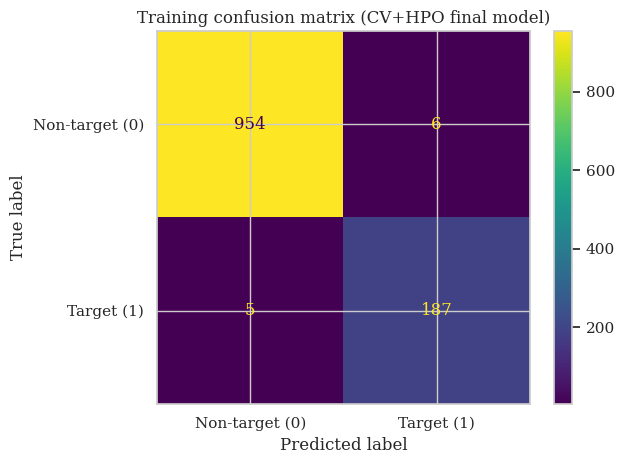

History columns: ['batches', 'epoch', 'train_batch_count', 'dur', 'train_loss', 'train_loss_best', 'train_accuracy', 'train_accuracy_best', 'train_bacc', 'train_bacc_best']


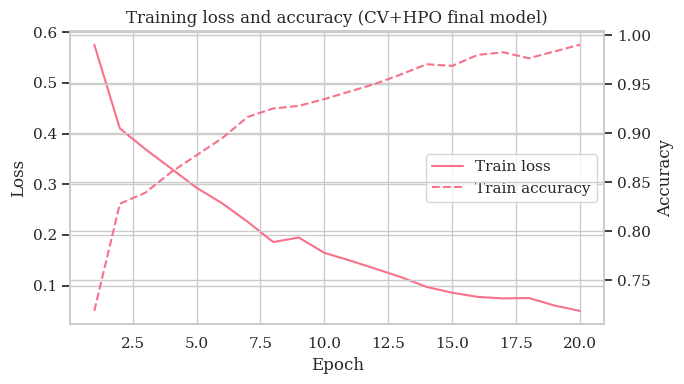

TEST y_true counts: Counter({0: 480, 1: 96})
TEST y_pred counts: Counter({0: 476, 1: 100})


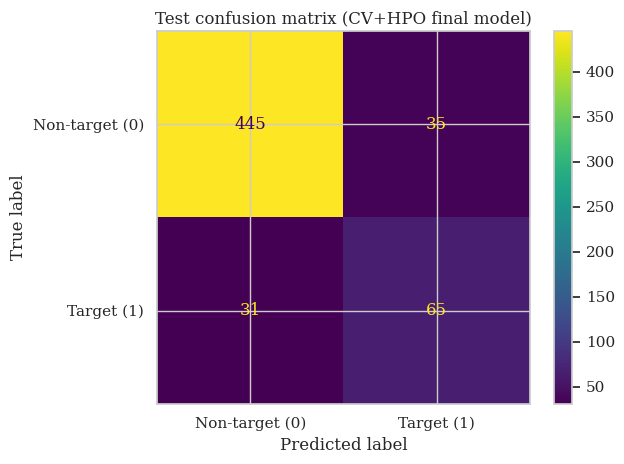

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# choose the model you want to plot for (CV+HPO final refit)
clf = final_clf

# label column (robust)
meta_train = train_set.get_metadata()
label_col = "target" if "target" in meta_train.columns else "label"

# TRAIN confusion matrix
y_true_train = meta_train[label_col].to_numpy().astype(int)
y_proba_train = clf.predict_proba(train_set)
y_pred_train = np.argmax(y_proba_train, axis=1)

print("TRAIN y_true counts:", Counter(y_true_train))
print("TRAIN y_pred counts:", Counter(y_pred_train))

cm_train = confusion_matrix(y_true_train, y_pred_train, labels=[0, 1])
ConfusionMatrixDisplay(cm_train, display_labels=["Non-target (0)", "Target (1)"]).plot(values_format="d")
plt.title("Training confusion matrix (CV+HPO final model)")
plt.tight_layout()
plt.show()

# TRAIN loss + accuracy curves (together)

history = pd.DataFrame(clf.history)
print("History columns:", list(history.columns))

epochs = history["epoch"]

fig, ax1 = plt.subplots(figsize=(7, 4))

# loss (left axis)
ax1.plot(epochs, history["train_loss"], label="Train loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# accuracy (right axis) if logged
if "train_accuracy" in history.columns:
    ax2 = ax1.twinx()
    ax2.plot(epochs, history["train_accuracy"], linestyle="--", label="Train accuracy")
    ax2.set_ylabel("Accuracy")

    # merged legend
    l1, lab1 = ax1.get_legend_handles_labels()
    l2, lab2 = ax2.get_legend_handles_labels()
    ax1.legend(l1 + l2, lab1 + lab2, loc="center right")
else:
    ax1.legend(loc="upper right")
    ax1.text(
        0.02, 0.02,
        "train_accuracy not logged (add EpochScoring callback)",
        transform=ax1.transAxes
    )

plt.title("Training loss and accuracy (CV+HPO final model)")
plt.tight_layout()
plt.show()

# 3) TEST confusion matrix
meta_test = test_set.get_metadata()
label_col_test = "target" if "target" in meta_test.columns else "label"
y_true_test = meta_test[label_col_test].to_numpy().astype(int)

y_proba_test = clf.predict_proba(test_set)
y_pred_test = np.argmax(y_proba_test, axis=1)

print("TEST y_true counts:", Counter(y_true_test))
print("TEST y_pred counts:", Counter(y_pred_test))

cm_test = confusion_matrix(y_true_test, y_pred_test, labels=[0, 1])
ConfusionMatrixDisplay(cm_test, display_labels=["Non-target (0)", "Target (1)"]).plot(values_format="d")
plt.title("Test confusion matrix (CV+HPO final model)")
plt.tight_layout()
plt.show()


History columns: ['batches', 'epoch', 'train_batch_count', 'dur', 'train_loss', 'train_loss_best', 'train_accuracy', 'train_accuracy_best', 'train_bacc', 'train_bacc_best']


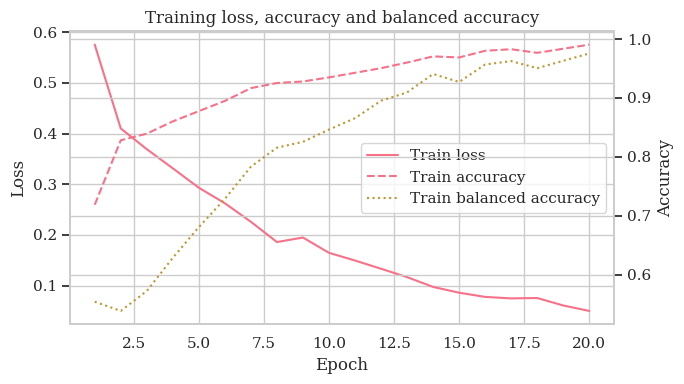

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

history = pd.DataFrame(clf.history)
print("History columns:", list(history.columns))

epochs = history["epoch"]

fig, ax1 = plt.subplots(figsize=(7, 4))

# Loss (left axis)
ax1.plot(epochs, history["train_loss"], label="Train loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Accuracy metrics (right axis)
ax2 = ax1.twinx()

if "train_accuracy" in history.columns:
    ax2.plot(
        epochs,
        history["train_accuracy"],
        linestyle="--",
        label="Train accuracy",
    )

if "train_bacc" in history.columns:
    ax2.plot(
        epochs,
        history["train_bacc"],
        linestyle=":",
        label="Train balanced accuracy",
    )

ax2.set_ylabel("Accuracy")

# Merge legends
l1, lab1 = ax1.get_legend_handles_labels()
l2, lab2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lab1 + lab2, loc="center right")

plt.title("Training loss, accuracy and balanced accuracy")
plt.tight_layout()
plt.show()


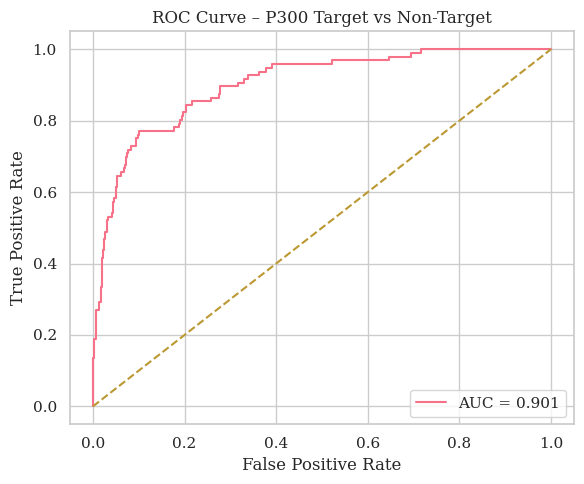

In [37]:
#ROC curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, proba[:, 1])

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – P300 Target vs Non-Target")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


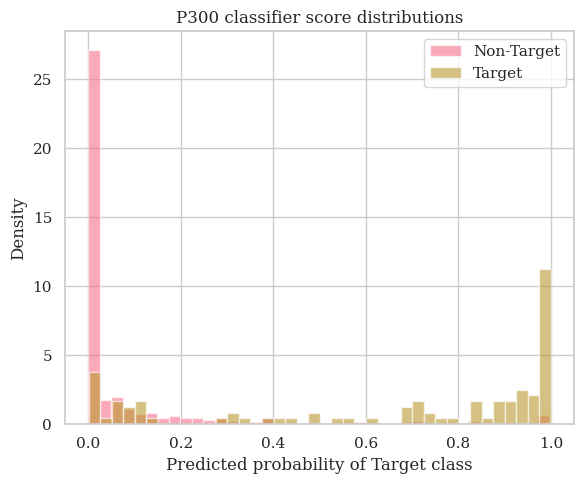

In [38]:
# predicted probability distributions

plt.figure(figsize=(6, 5))

plt.hist(
    proba[y_true == 0, 1],
    bins=40,
    alpha=0.6,
    label="Non-Target",
    density=True,
)

plt.hist(
    proba[y_true == 1, 1],
    bins=40,
    alpha=0.6,
    label="Target",
    density=True,
)

plt.xlabel("Predicted probability of Target class")
plt.ylabel("Density")
plt.title("P300 classifier score distributions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Plot Results (without CV and HPO)

TRAIN y_true counts: Counter({0: 960, 1: 192})
TRAIN y_pred counts: Counter({0: 960, 1: 192})


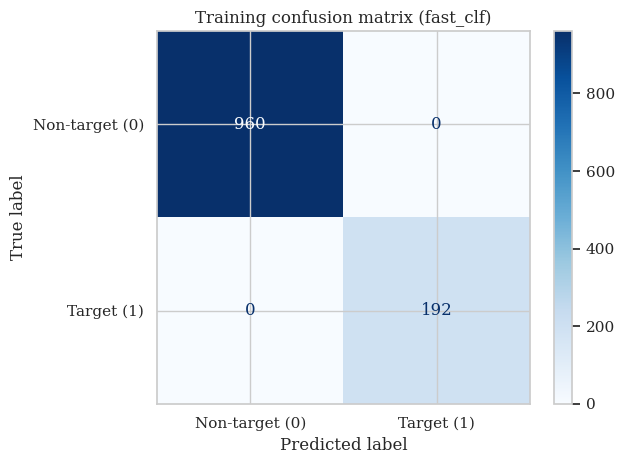

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# true labels from training metadata
meta_train = train_set.get_metadata()
label_col = "target" if "target" in meta_train.columns else "label"
y_true_train = meta_train[label_col].to_numpy().astype(int)

# predictions on training set
y_proba_train = fast_clf.predict_proba(train_set)
y_pred_train = np.argmax(y_proba_train, axis=1)

# sanity checks (helps catch class collapse)
print("TRAIN y_true counts:", Counter(y_true_train))
print("TRAIN y_pred counts:", Counter(y_pred_train))

# confusion matrix (force 2x2)
cm_train = confusion_matrix(y_true_train, y_pred_train, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_train,
    display_labels=["Non-target (0)", "Target (1)"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Training confusion matrix (fast_clf)")
plt.tight_layout()
plt.show()


History columns: ['batches', 'epoch', 'train_batch_count', 'dur', 'train_loss', 'train_loss_best', 'train_accuracy', 'train_accuracy_best', 'train_bacc', 'train_bacc_best']


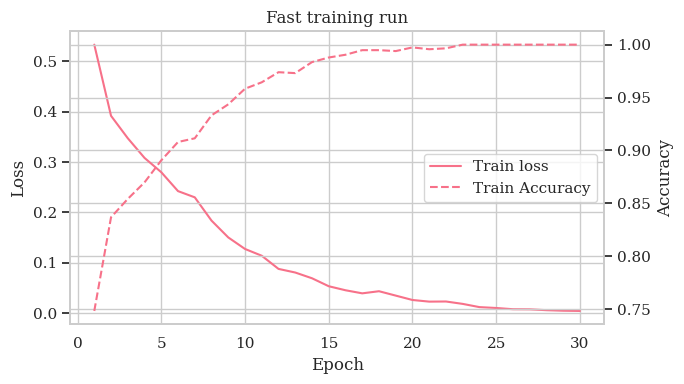

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(clf, title="Training curves"):
    hist = pd.DataFrame(clf.history)
    print("History columns:", list(hist.columns))

    epochs = hist["epoch"]

    fig, ax1 = plt.subplots(figsize=(7, 4))

    # Left axis: loss
    ax1.plot(epochs, hist["train_loss"], label="Train loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True)

    # Right axis: accuracy (only if logged)
    acc_cols = [c for c in ["train_accuracy", "valid_accuracy"] if c in hist.columns]
    if acc_cols:
        ax2 = ax1.twinx()
        for c in acc_cols:
            ax2.plot(epochs, hist[c], linestyle="--", label=c.replace("_", " ").title())
        ax2.set_ylabel("Accuracy")

        # Merge legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")
    else:
        ax1.legend(loc="upper right")

    plt.title(title)
    plt.tight_layout()
    plt.show()

# Usage
plot_loss_and_accuracy(fast_clf, title="Fast training run")
# plot_loss_and_accuracy(best_clf, title="Best HPO training run")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history = pd.DataFrame(fast_clf.history)
print("History columns:", list(history.columns))

epochs = history["epoch"]

fig, ax1 = plt.subplots(figsize=(7, 4))

# Loss (left axis)
ax1.plot(epochs, history["train_loss"], label="Train loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Accuracy metrics (right axis)
ax2 = ax1.twinx()

if "train_accuracy" in history.columns:
    ax2.plot(
        epochs,
        history["train_accuracy"],
        linestyle="--",
        label="Train accuracy",
    )

if "train_bacc" in history.columns:
    ax2.plot(
        epochs,
        history["train_bacc"],
        linestyle=":",
        label="Train balanced accuracy",
    )

ax2.set_ylabel("Accuracy")

# Merge legends
l1, lab1 = ax1.get_legend_handles_labels()
l2, lab2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lab1 + lab2, loc="center right")

plt.title("Training loss, accuracy and balanced accuracy (no CV/HPO)")
plt.tight_layout()
plt.show()


y_true counts: Counter({0: 480, 1: 96})
y_pred counts: Counter({0: 501, 1: 75})


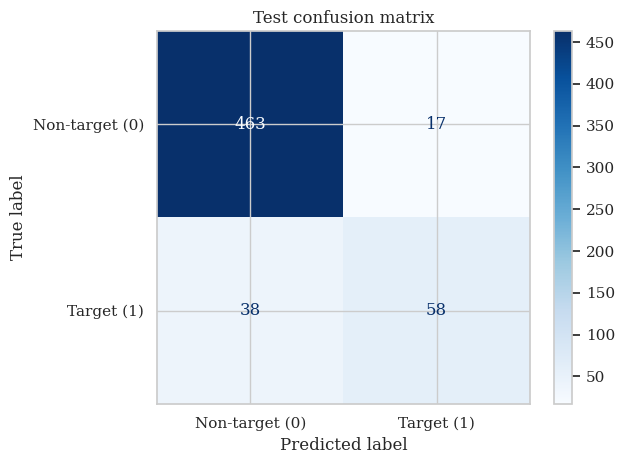

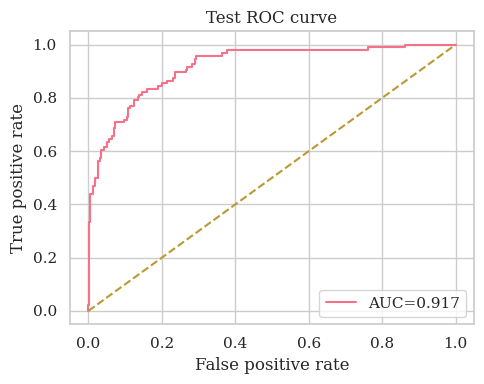

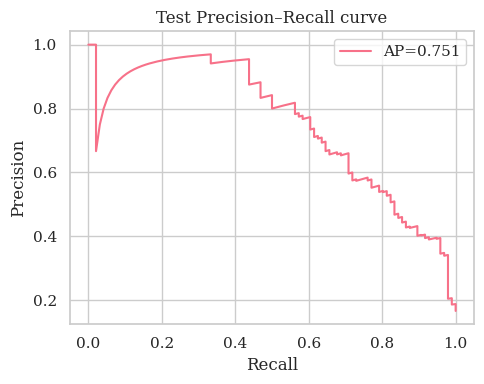

y_true counts: Counter({0: 480, 1: 96})
y_pred counts: Counter({0: 501, 1: 75})


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# extract true labels from test metadata
meta_test = test_set.get_metadata()
label_col = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col].to_numpy().astype(int)

# model predictions
y_proba = fast_clf.predict_proba(test_set)
y_pred = np.argmax(y_proba, axis=1)

# sanity checks (VERY useful)
print("y_true counts:", Counter(y_true))
print("y_pred counts:", Counter(y_pred))

# confusion matrix (force 2x2)
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-target (0)", "Target (1)"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Test confusion matrix")
plt.tight_layout()
plt.show()


# ROC curve
if has_both:
    fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1])
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("Test ROC curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Precision-Recall curve (often more informative for P300 imbalance)
if has_both:
    precision, recall, _ = precision_recall_curve(y_true, y_proba[:, 1])
    plt.figure(figsize=(5, 4))
    plt.plot(recall, precision, label=f"AP={ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Test Precision–Recall curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# sanity prints for the "only two squares filled" confusion matrix issue
from collections import Counter
print("y_true counts:", Counter(y_true))
print("y_pred counts:", Counter(y_pred))

# EEGNet

Adapted from https://braindecode.org/stable/generated/braindecode.models.EEGNet.html
We train the model on the same exact windows and data splits as before but use EEGNet instead. 

### Model from Lawhern et al., 2018

## Infer input dimensions
We try to infer n_chans and n_times from the first window in training set. Braindecode WindowDataset returns (X,y,i) in __getitem__, where X is a torch.Tensor with shape (n_chans, n_times) OR sometimes (1, n_chans, n_times) depending on transforms. 

In [25]:
import torch
import numpy as np
from collections import Counter

from braindecode.models import EEGNet
from braindecode import EEGClassifier

X0 = train_set[0][0]  # get first window data
if isinstance(X0, np.ndarray):
    X0 = torch.tensor(X0)

# Sometimes people end up with (1, n_chans, n_times) depending on transforms
if X0.ndim == 3 and X0.shape[0] == 1:
    X0 = X0.squeeze(0)

if X0.ndim != 2:
    raise RuntimeError(f"Expected 2D data (n_chans, n_times), got shape: {tuple(X0.shape)}")

n_chans = int(X0.shape[0])
n_times = int(X0.shape[1])

# infer label columns name from metadata
meta_train = train_set.get_metadata()
label_col = "target" if "target" in meta_train.columns else "label"
y_train = meta_train[label_col].to_numpy().astype(int)

classes = np.unique(y_train)
n_classes = int(classes.size)

print("Label column:", label_col)
print("Classes found:", classes, "n_classes:", n_classes)
print("EEGNet input dims:", "n_chans =", n_chans, "n_times =", n_times)
print("Train label counts:", Counter(y_train))


Label column: target
Classes found: [0 1] n_classes: 2
EEGNet input dims: n_chans = 16 n_times = 409
Train label counts: Counter({0: 960, 1: 192})


In [27]:
# set device (check if GPU is available) and seeds (for reproducibility)
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"

if cuda:
    torch.backends.cudnn.benchmark = True

set_random_seeds(seed=20200220, cuda=cuda)

print("Using device:", device)

Using device: cpu


## Build EEGNet model

In [28]:
# EEGNet has several architecture paramters
# We keep defaults first -> After you get a baseline, you can tune F1, D, kernel_length, drop_prob, etc.

eegnet_model = EEGNet(
    n_chans=n_chans,
    n_outputs=n_classes,
    n_times=n_times,
    final_conv_length="auto", # infer final layer size
    # pool_mode="mean", # default; you can switch to "max" pooling if you want
    # drop_prob=0.25,   # default dropout probability
).to(device)

print(eegnet_model)


Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
EEGNet (EEGNet)                                              [1, 16, 409]              [1, 2]                    --                        --
├─Ensure4d (ensuredims): 1-1                                 [1, 16, 409]              [1, 16, 409, 1]           --                        --
├─Rearrange (dimshuffle): 1-2                                [1, 16, 409, 1]           [1, 1, 16, 409]           --                        --
├─Conv2d (conv_temporal): 1-3                                [1, 1, 16, 409]           [1, 8, 16, 410]           512                       [1, 64]
├─BatchNorm2d (bnorm_temporal): 1-4                          [1, 8, 16, 410]           [1, 8, 16, 410]           16                        --
├─ParametrizedConv2dWithConstraint (conv_spatial): 1-5       [1, 8, 16, 410]           [1, 16, 1, 410]           --                  

## EEGNet fast baseline (no CV, no HPO)

In [ ]:
from skorch.callbacks import EpochScoring
from sklearn.metrics import balanced_accuracy_score, make_scorer

# Accuracy (train)
train_acc_cb = EpochScoring(
    scoring="accuracy",
    on_train=True,
    name="train_accuracy",
    lower_is_better=False,
)

# Balanced accuracy (train)
train_bacc_cb = EpochScoring(
    scoring=make_scorer(balanced_accuracy_score),
    on_train=True,
    name="train_balanced_accuracy",
    lower_is_better=False,
)
# Accuracy (valid)
valid_acc_cb = EpochScoring(
    scoring="accuracy",
    on_train=False,
    name="valid_accuracy",
    lower_is_better=False,
)
# Balanced accuracy (valid)
valid_bacc_cb = EpochScoring(
    scoring=make_scorer(balanced_accuracy_score),
    on_train=False,
    name="valid_balanced_accuracy",
    lower_is_better=False,
)


# Fast baseline hyperparams based on first run of CV and HPO
lr = 0.00038809762950116534
batch_size = 32
weight_decay: 0.000997517836738623
drop_prob: 0.530710204487765
F1: 16
D: 4
kernel_length: 128
max_epochs = 21

clf_eegnet_fast = EEGClassifier(
    eegnet_model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=lr,
    batch_size=batch_size,
    max_epochs=max_epochs,
    device=device,
    iterator_train__shuffle=True,
    train_split=None,
    classes=list(range(n_classes)),
    callbacks=[
        ("train_accuracy", train_acc_cb),
        ("train_balanced_accuracy", train_bacc_cb),
        ("valid_accuracy", valid_acc_cb),
        ("valid_balanced_accuracy", valid_bacc_cb),
    ],
)

# Fit once on full training set
clf_eegnet_fast.fit(train_set, y=None)

  epoch    train_accuracy    train_balanced_accuracy    train_loss     dur
-------  ----------------  -------------------------  ------------  ------
      1            0.9661                     0.9297        0.0875  6.2189
      2            0.9644                     0.9245        0.0995  4.5728
      3            0.9679                     0.9411        0.0895  2.9721
      4            0.9688                     0.9354        0.0866  2.9535
      5            0.9549                     0.9062        0.0963  2.5902
      6            0.9653                     0.9333        0.0863  2.7161
      7            0.9618                     0.9208        0.0940  2.4877
      8            0.9696                     0.9359        0.0800  2.5340
      9            0.9635                     0.9302        0.0833  2.5244
     10            0.9757                     0.9479        0.0769  2.6581
     11            0.9679                     0.9328        0.0937  2.5279
     12            0.9740

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNet (EEGNet)                                              [1, 16, 409]              [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                                 [1, 16, 409]              [1, 16, 409, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2                                [1, 16, 409, 1]           [1, 1, 16, 409]           --                        --
  ├─Conv2d (conv_temporal): 1-3                                [1, 1, 16, 409]           [1, 8, 16, 410]           512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                          [1, 8, 16, 410]           [1, 8, 16, 410]           16                        --
  ├─ParametrizedConv2dWithConstraint (conv_spatial): 1-5       [1, 8, 16, 410]           [1, 16, 1, 410]           --                        [16, 1]
  │    └─ModuleDict (parametrizations): 2-1                    --                        --                        --                        --
  │    │    └─ParametrizationList (weight): 3-1                --                        [16, 1, 16, 1]            256                       --
  ├─BatchNorm2d (bnorm_1): 1-6                                 [1, 16, 1, 410]           [1, 16, 1, 410]           32                        --
  ├─ELU (elu_1): 1-7                                           [1, 16, 1, 410]           [1, 16, 1, 410]           --                        --
  ├─AvgPool2d (pool_1): 1-8                                    [1, 16, 1, 410]           [1, 16, 1, 102]           --                        [1, 4]
  ├─Dropout (drop_1): 1-9                                      [1, 16, 1, 102]           [1, 16, 1, 102]           --                        --
  ├─Conv2d (conv_separable_depth): 1-10                        [1, 16, 1, 102]           [1, 16, 1, 103]           256                       [1, 16]
  ├─Conv2d (conv_separable_point): 1-11                        [1, 16, 1, 103]           [1, 16, 1, 103]           256                       [1, 1]
  ├─BatchNorm2d (bnorm_2): 1-12                                [1, 16, 1, 103]           [1, 16, 1, 103]           32                        --
  ├─ELU (elu_2): 1-13                                          [1, 16, 1, 103]           [1, 16, 1, 103]           --                        --
  ├─AvgPool2d (pool_2): 1-14                                   [1, 16, 1, 103]           [1, 16, 1, 12]            --                        [1, 8]
  ├─Dropout (drop_2): 1-15                                     [1, 16, 1, 12]            [1, 16, 1, 12]            --                        --
  ├─Sequential (final_layer): 1-16                             [1, 16, 1, 12]            [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-2                         [1, 16, 1, 12]            [1, 2, 1, 1]              386                       [1, 12]
  │    └─Rearrange (permute_back): 2-3                         [1, 2, 1, 1]              [1, 2, 1, 1]              --                        --
  │    └─SqueezeFinalOutput (squeeze): 2-4                     [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-2                         [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  =========================================================================================================

### Evaluate of test set

In [42]:
meta_test = test_set.get_metadata()
label_col_test = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col_test].to_numpy().astype(int)

y_proba = clf_eegnet_fast.predict_proba(test_set)
y_pred = np.argmax(y_proba, axis=1)

acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

if y_proba.shape[1] == 2 and len(np.unique(y_true)) == 2:
    auc = roc_auc_score(y_true, y_proba[:, 1])
    ap  = average_precision_score(y_true, y_proba[:, 1])
else:
    auc = float("nan")
    ap  = float("nan")

print("EEGNet FAST baseline (test)")
print(f"  accuracy: {acc:.4f}")
print(f"  balanced_accuracy: {bacc:.4f}")
print(f"  roc_auc: {auc:.4f}")
print(f"  avg_precision: {ap:.4f}")

EEGNet FAST baseline (test)
  accuracy: 0.9080
  balanced_accuracy: 0.8365
  roc_auc: 0.9144
  avg_precision: 0.7961


## EEGNet with HPO and CV

In this section we tune EEGNet hyperparamters using optuna. Each optuna trial is evaluated via GroupKFold cross-validation and we optimise mean balanced accuracy across folds.

In [ ]:
from sklearn.model_selection import GroupKFold
from torch.utils.data import Subset

from skorch.callbacks import EpochScoring, EarlyStopping
from sklearn.metrics import balanced_accuracy_score, make_scorer
from skorch.helper import predefined_split

def build_eegnet_clf(
    n_chans, 
    n_times, 
    n_classes, 
    device, 
    lr, 
    batch_size, 
    weight_decay, 
    drop_prob, 
    F1, 
    D, 
    kernel_length, 
    depthwise_kernel_length,
    max_epochs,
    valid_ds=None,
    patience=10,
    monitor="valid_loss",
):
    
    # Accuracy (train)
    train_acc_cb = EpochScoring(
        scoring="accuracy",
        on_train=True,
        name="train_accuracy",
        lower_is_better=False,
    )

    # Balanced accuracy (train)
    train_bacc_cb = EpochScoring(
        scoring=make_scorer(balanced_accuracy_score),
        on_train=True,
        name="train_balanced_accuracy",
        lower_is_better=False,
    )
    # Accuracy (valid)
    valid_acc_cb = EpochScoring(
        scoring="accuracy",
        on_train=False,
        name="valid_accuracy",
        lower_is_better=False,
    )
    # Balanced accuracy (valid)
    valid_bacc_cb = EpochScoring(
        scoring=make_scorer(balanced_accuracy_score),
        on_train=False,
        name="valid_balanced_accuracy",
        lower_is_better=False,
    )
    # Create a fresh EEGNet + EEGClassifier for a given hyperparameter configuration.
    # We build a new model each time so folds and trials do not leak state.
    model = EEGNet(
        n_chans=n_chans,
        n_outputs=n_classes,
        n_times=n_times,
        final_conv_length="auto",
        drop_prob=drop_prob,
        F1=F1,
        D=D,
        kernel_length=kernel_length,
        depthwise_kernel_length=depthwise_kernel_length,
    ).to(device)

    clf = EEGClassifier(
        model,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        max_epochs=max_epochs,
        device=device,
        iterator_train__shuffle=True,
        train_split=(predefined_split(valid_ds) if valid_ds is not None else None), 
        classes=list(range(n_classes)),
        callbacks=[
            ("train_accuracy", train_acc_cb),
            ("train_balanced_accuracy", train_bacc_cb),
            ("valid_accuracy", valid_acc_cb),
            ("valid_balanced_accuracy", valid_bacc_cb),
            ("early_stopping", EarlyStopping(
                monitor=monitor,
                patience=patience,
                lower_is_better=(monitor in ["valid_loss", "train_loss"]), # final model will look at train loss for early stopping
                threshold=1e-4,
                threshold_mode="rel",
                load_best=True
            )),
        ],
    )
    return clf


**Trying with optuna**
- Automated loop that tries hyperparamter combinations and keeps best one depending on single score chosen (different than one used in ShallowNet).
- Optuna keeps track of scores and decides what to do next. 
- Optuna prunes trials that look bad based on intermediate results.
    - MedianPruner logic:
        - Optuna looks at the distribution of intermediate scores from previous trials in that step and if current trial's intermediate score is worse than median, it gets pruned.
- Every paramter combination trained and evaluated across CV folds (unless pruned).
    - The loop folds:
        - build model with those hyperparameters.
        - fit on training fold.
        - predict on validation fold.
        - compute balanced accuracy.
    - Return mean fold score.
- study.optimize:
    - optuna runs objective(trial) up to n_trials and each run is a new hyperparameter suggestion.

**Continuous Paramters**
- Log: samples log space between values
    - lr
- Uniform sampling: samples over those ranges
    - weight decay, drop_prob
**Discrete choices**
- picks one option each
    - batch size, f1, D, kernel length
**Integer range**
- picks integer in range
    - max epochs

**TPE (tree-structured parzen estimator)**
- It is a Bayesian optimisation style sampler
- Intuition:
    - after some trials, Optuna splits observed trials into "good" trials (high objective values) and "bad" trials (low objective values)
    - It models where "good" hyperparamters tend to lie and then samples new candidates that are more likely to come from the "good" region"
- Early trials are more exploratory, while later trials are more likely to come from a good region

**Training parameters:**\
learning rate (lr): controls how big each gradient update is (too big=unstable training, too low=very slow learning).

batch_size: number of trials processed before one optimiser update (smaller=noisier gradients, more regularisation and larger=smoother gradients, can overfit more easily).

weight_decay: L2 regularisation strength (penalises large weights to prevent overfitting).

drop_prob (dropout prob): fraction of activations randomly set to zero during training (too low=weak regularisation and too high=underfitting).

max_epochs: number of full passes over training data (more=better convergence but risk of overfitting).

**EEGNet architecture parameters:**\
F1 (number of temporal filters): filters in first temporal convolution layer. Controls how many distinct temporal patterns are learned (larger=more expressive temporal modelling but higher risk of overfitting).

kernel_length: length of temporal convolution kernel (in samples). Determines the temporal window the model "sees" at once. Short kenerls capture sharp/fast components while longer ones capture slow/sustained ERP components.

D (depth multiplier): controls how many spatial filters are learned per temporal filter. Implemented via depthwise convolution. Larger D means more spatial patterns per frequency/temporal feature and more paramters.








In [ ]:
import optuna
from sklearn.metrics import balanced_accuracy_score

MAX_EPOCHS = 80

def objective(trial: optuna.Trial) -> float:
    print(f"Trial {trial.number} started")
    # Hyperparameter search space (moderate ranges for EEGNet)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    drop_prob = trial.suggest_float("drop_prob", 0.1, 0.6)

    # EEGNet architecture knobs
    F1 = trial.suggest_categorical("F1", [4, 8, 16, 32])
    D = trial.suggest_categorical("D", [1, 2, 4])
    kernel_length = trial.suggest_categorical("kernel_length", [16, 32, 64, 96, 128])
    depthwise_kernel_length = trial.suggest_categorical("depthwise_kernel_length", [8, 16, 24, 32])

    patience = trial.suggest_int("patience", 8, 15)

    max_epochs = MAX_EPOCHS

    fold_scores = []

    # Loop folds
    for fold_idx, (tr_idx, va_idx) in enumerate(cv.split(np.zeros(len(train_set)), y_train, groups)):
        set_random_seeds(seed=2025 + fold_idx, cuda=cuda)

        tr_ds_full = Subset(train_set, tr_idx)
        va_ds = Subset(train_set, va_idx)

        # Inner split inside the training fold for early stopping
        n_tr = len(tr_ds_full)
        rng = np.random.RandomState(2025 + fold_idx)
        perm = rng.permutation(n_tr)
        n_valid_inner = max(1, int(0.2 * n_tr))

        inner_valid_idx = perm[:n_valid_inner]
        inner_train_idx = perm[n_valid_inner:]

        inner_train_ds = Subset(tr_ds_full, inner_train_idx)
        inner_valid_ds = Subset(tr_ds_full, inner_valid_idx)

        clf = build_eegnet_clf(
            n_chans=n_chans,
            n_times=n_times,
            n_classes=n_classes,
            device=device,
            lr=lr,
            batch_size=batch_size,
            weight_decay=weight_decay,
            drop_prob=drop_prob,
            F1=F1,
            D=D,
            kernel_length=kernel_length,
            max_epochs=max_epochs,
            depthwise_kernel_length=depthwise_kernel_length,
            valid_ds=inner_valid_ds,
            patience=patience,
            monitor="valid_loss",
        )

        clf.fit(inner_train_ds, y=None)

        # Validation predictions
        y_va_true = y_train[va_idx]
        y_va_proba = clf.predict_proba(va_ds)
        y_va_pred = np.argmax(y_va_proba, axis=1)

        fold_bacc = balanced_accuracy_score(y_va_true, y_va_pred)
        fold_scores.append(fold_bacc)

        # Report intermediate score so Optuna can prune bad trials
        trial.report(np.mean(fold_scores), step=fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

    print(f"Trial {trial.number} finished | mean balanced accuracy: {np.mean(fold_scores):.4f}")
    return float(np.mean(fold_scores))


Run the HPO

In [ ]:
# starting small to verify everything runs
n_trials = 30

sampler = optuna.samplers.TPESampler(seed=2025)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=n_trials)

print("Best CV score (mean balanced accuracy):", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

### Refit best EEGNet on full training set and evaluate on test set

In [ ]:
best = study.best_params

# Build final clf using best params
set_random_seeds(seed=2025, cuda=torch.cuda.is_available())

final_clf_eegnet = build_eegnet_clf(
    n_chans=n_chans,
    n_times=n_times,
    n_classes=n_classes,
    device=device,
    lr=best["lr"],
    batch_size=best["batch_size"],
    weight_decay=best["weight_decay"],
    drop_prob=best["drop_prob"],
    F1=best["F1"],
    D=best["D"],
    kernel_length=best["kernel_length"],
    depthwise_kernel_length=best["depthwise_kernel_length"],
    max_epochs=MAX_EPOCHS,
    patience=best["patience"],
    monitor="train_loss",  # final model uses train loss for early stopping
)

final_clf_eegnet.fit(train_set, y=None)

# Test evaluation
meta_test = test_set.get_metadata()
label_col_test = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col_test].to_numpy().astype(int)

y_proba = final_clf_eegnet.predict_proba(test_set)
y_pred = np.argmax(y_proba, axis=1)

acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

if y_proba.shape[1] == 2 and len(np.unique(y_true)) == 2:
    auc = roc_auc_score(y_true, y_proba[:, 1])
    ap  = average_precision_score(y_true, y_proba[:, 1])
else:
    auc = float("nan")
    ap  = float("nan")

print("EEGNet HPO+CV (test)")
print(f"  accuracy: {acc:.4f}")
print(f"  balanced_accuracy: {bacc:.4f}")
print(f"  roc_auc: {auc:.4f}")
print(f"  avg_precision: {ap:.4f}")


NameError: name 'build_eegnet_clf' is not defined

## Plots

Functions and imports to plot

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    balanced_accuracy_score,
    accuracy_score,
)

def _get_y_true(ds, label_col_preference=("target", "label")) -> np.ndarray:
    meta = ds.get_metadata()
    for col in label_col_preference:
        if col in meta.columns:
            return meta[col].to_numpy().astype(int)
    # fallback: second element of each item (works for many datasets, but slower)
    return np.array([ds[i][1] for i in range(len(ds))], dtype=int)

def _get_proba_and_pred(clf, ds):
    """
    Returns:
      y_true: (n,)
      y_proba: (n, 2) for binary OR (n, n_classes) for multiclass
      y_pred: (n,)
    """
    y_true = _get_y_true(ds)

    # EEGClassifier exposes predict_proba / predict in most setups
    y_proba = clf.predict_proba(ds)
    y_pred = clf.predict(ds)

    y_proba = np.asarray(y_proba)
    y_pred = np.asarray(y_pred).astype(int)
    return y_true, y_proba, y_pred

def plot_confmat(y_true, y_pred, title="Confusion matrix", normalize=None):
    #normalize: None | "true" | "pred" | "all" (sklearn option)
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots()
    disp.plot(ax=ax, values_format=".2f" if normalize else "d", colorbar=False)
    ax.set_title(title)
    plt.show()


def plot_history_loss_and_accuracy(clf, title="Training curves (loss + accuracy)"):
    """
    Plots loss and (if available) accuracy on the same figure using twin y-axes.
    Compatible with multiple skorch versions.
    """

    hist_obj = getattr(clf, "history", None)
    if hist_obj is None:
        print("No clf.history found. Did you fit the model?")
        return

    # skorch History often supports .to_list()
    if hasattr(hist_obj, "to_list"):
        hist = pd.DataFrame(hist_obj.to_list())
    else:
        # fallback: try to coerce history directly
        try:
            hist = pd.DataFrame(hist_obj)
        except Exception:
            print("Could not convert clf.history to a table. Available:", dir(hist_obj))
            return

    if hist.empty:
        print("History is empty. Did training run?")
        return

    # Identify columns (names differ depending on callbacks and versions)
    loss_candidates = ["train_loss", "valid_loss"]
    acc_candidates = ["train_accuracy", "valid_accuracy", "train_acc", "valid_acc", "accuracy", "acc"]

    loss_cols = [c for c in loss_candidates if c in hist.columns]
    acc_cols = [c for c in acc_candidates if c in hist.columns]

    # If you have epochs in history, use them, else use index
    x = hist["epoch"].values if "epoch" in hist.columns else np.arange(len(hist))

    fig, ax1 = plt.subplots()
    ax1.set_title(title)
    ax1.set_xlabel("Epoch")

    if loss_cols:
        for c in loss_cols:
            ax1.plot(x, hist[c].values, label=c)
        ax1.set_ylabel("Loss")
    else:
        ax1.text(0.5, 0.5, f"No loss columns found. Columns: {list(hist.columns)}",
                 ha="center", va="center")
        plt.show()
        return

    if acc_cols:
        ax2 = ax1.twinx()
        for c in acc_cols:
            ax2.plot(x, hist[c].values, linestyle=":", label=c)
        ax2.set_ylabel("Accuracy")

        # Merge legends from both axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
    else:
        ax1.legend(loc="best")
        print("Note: No accuracy columns found in history. Add an EpochScoring accuracy callback to log it.")

    plt.show()

def plot_history_loss_acc_bacc(clf, title="Training curves"):
    hist = pd.DataFrame(clf.history.to_list())  # works across skorch versions
    x = hist["epoch"].values if "epoch" in hist.columns else np.arange(len(hist))

    loss_cols = [c for c in ["train_loss", "valid_loss"] if c in hist.columns]
    acc_cols  = [c for c in ["train_accuracy", "valid_accuracy"] if c in hist.columns]
    bacc_cols = [c for c in ["train_balanced_accuracy", "valid_balanced_accuracy"] if c in hist.columns]

    fig, ax1 = plt.subplots()
    ax1.set_title(title)
    ax1.set_xlabel("Epoch")

    for c in loss_cols:
        ax1.plot(x, hist[c].values, label=c)
    ax1.set_ylabel("Loss")

    ax2 = ax1.twinx()
    for c in acc_cols:
        ax2.plot(x, hist[c].values, linestyle=":", label=c)
    for c in bacc_cols:
        ax2.plot(x, hist[c].values, linestyle="--", label=c)
    ax2.set_ylabel("Score")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
    plt.show()

def plot_roc_and_pr(y_true, y_proba, title_prefix="Curves"):
    """
    Plots ROC and Precision Recall for binary classification.
    If not binary, it will still try but may skip AUC/AP.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    is_binary = (y_proba.ndim == 2 and y_proba.shape[1] == 2 and len(np.unique(y_true)) == 2)

    if is_binary:
        scores = y_proba[:, 1]
        fpr, tpr, _ = roc_curve(y_true, scores)
        auc = roc_auc_score(y_true, scores)

        axes[0].plot(fpr, tpr)
        axes[0].set_title(f"{title_prefix}: ROC (AUC={auc:.3f})")
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")

        prec, rec, _ = precision_recall_curve(y_true, scores)
        ap = average_precision_score(y_true, scores)

        axes[1].plot(rec, prec)
        axes[1].set_title(f"{title_prefix}: Precision-Recall (AP={ap:.3f})")
        axes[1].set_xlabel("Recall")
        axes[1].set_ylabel("Precision")
    else:
        axes[0].text(0.5, 0.5, "ROC curve: binary only", ha="center", va="center")
        axes[1].text(0.5, 0.5, "PR curve: binary only", ha="center", va="center")

    plt.tight_layout()
    plt.show()


def print_basic_metrics(y_true, y_proba, y_pred, header="Metrics"):
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)

    auc = np.nan
    ap = np.nan
    is_binary = (y_proba.ndim == 2 and y_proba.shape[1] == 2 and len(np.unique(y_true)) == 2)
    if is_binary:
        auc = roc_auc_score(y_true, y_proba[:, 1])
        ap = average_precision_score(y_true, y_proba[:, 1])

    print(header)
    print(f"  accuracy:          {acc:.4f}")
    print(f"  balanced_accuracy: {bacc:.4f}")
    print(f"  roc_auc:           {auc:.4f}")
    print(f"  avg_precision:     {ap:.4f}")


### No HPO and CV

Training plots

NO HPO/CV (train)
  accuracy:          0.9887
  balanced_accuracy: 0.9849
  roc_auc:           0.9993
  avg_precision:     0.9968


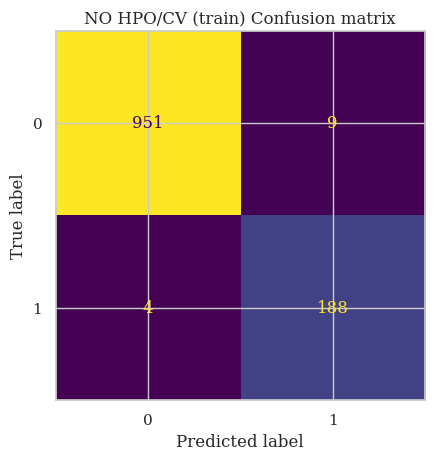

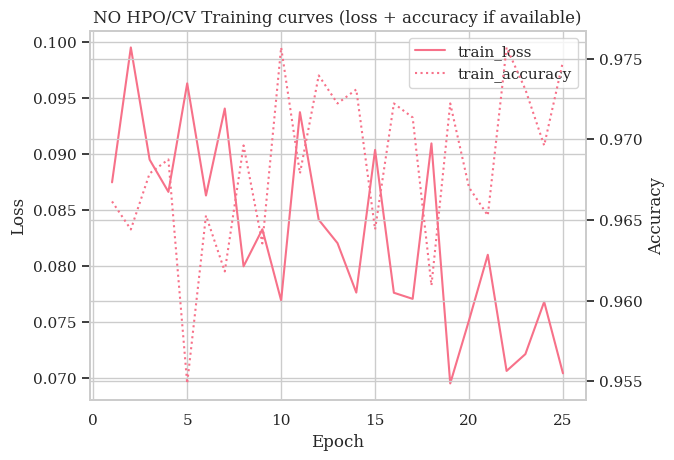

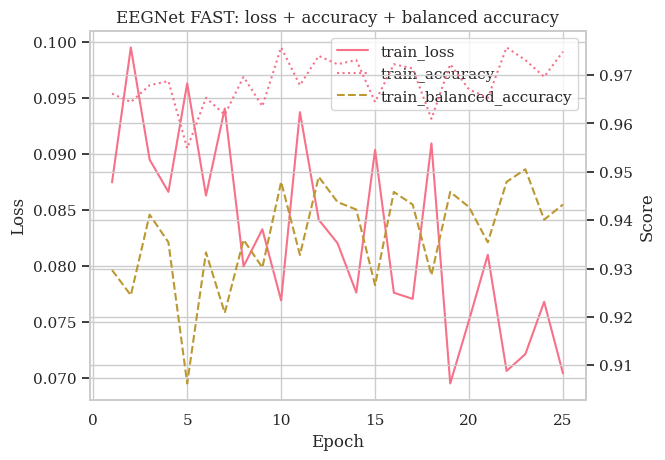

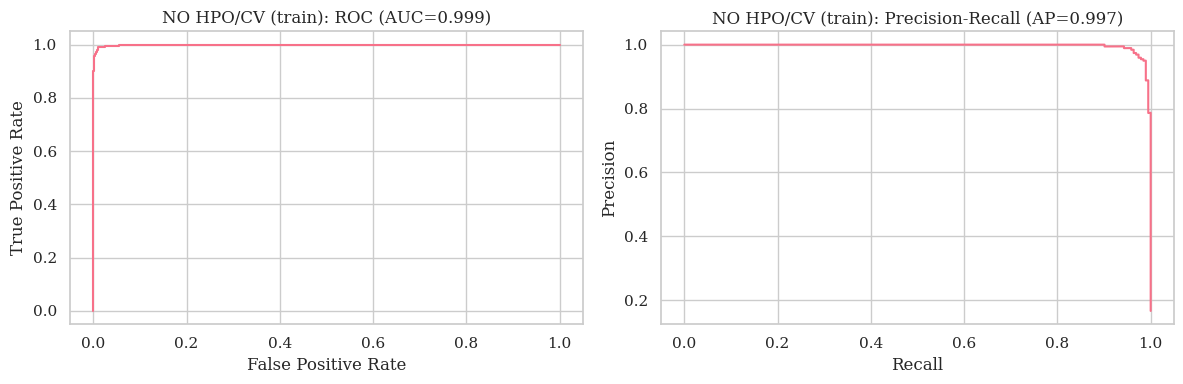

In [44]:
# training plots (confusion matrix, loss+accuracy, ROC+PR, balanced accuracy)

y_true_tr, y_proba_tr, y_pred_tr = _get_proba_and_pred(clf_eegnet_fast, train_set)

print_basic_metrics(y_true_tr, y_proba_tr, y_pred_tr, header="NO HPO/CV (train)")

plot_confmat(
    y_true_tr,
    y_pred_tr,
    title="NO HPO/CV (train) Confusion matrix",
    normalize=None
)

plot_history_loss_and_accuracy(
    clf_eegnet_fast,
    title="NO HPO/CV Training curves (loss + accuracy if available)"
)

plot_history_loss_acc_bacc(
    clf_eegnet_fast, title="EEGNet FAST: loss + accuracy + balanced accuracy"
)

plot_roc_and_pr(
    y_true_tr,
    y_proba_tr,
    title_prefix="NO HPO/CV (train)"
)


Test plots

NO HPO/CV (test)
  accuracy:          0.9080
  balanced_accuracy: 0.8365
  roc_auc:           0.9144
  avg_precision:     0.7961


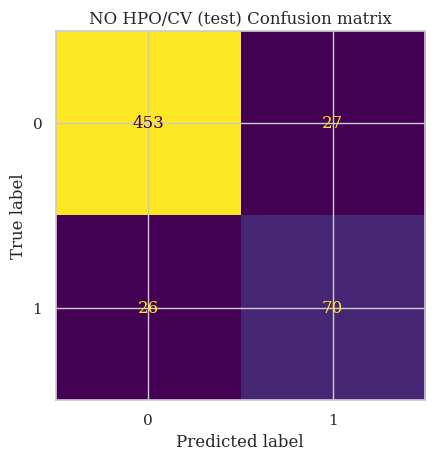

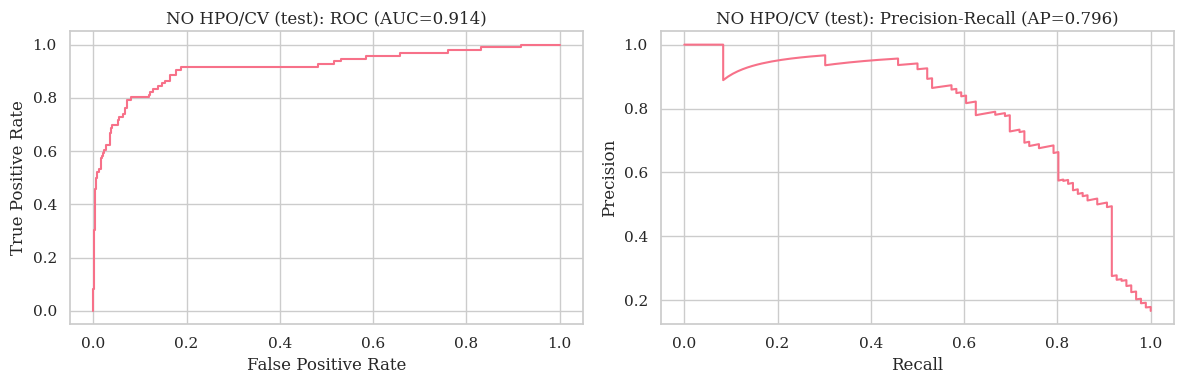

In [46]:
y_true_te, y_proba_te, y_pred_te = _get_proba_and_pred(clf_eegnet_fast, test_set)

print_basic_metrics(y_true_te, y_proba_te, y_pred_te, header="NO HPO/CV (test)")

plot_confmat(
    y_true_te,
    y_pred_te,
    title="NO HPO/CV (test) Confusion matrix",
    normalize=None
)

plot_roc_and_pr(
    y_true_te,
    y_proba_te,
    title_prefix="NO HPO/CV (test)"
)


### HPO and CV

Training plots

HPO+CV (train)
  accuracy:          0.9497
  balanced_accuracy: 0.9510
  roc_auc:           0.9908
  avg_precision:     0.9692


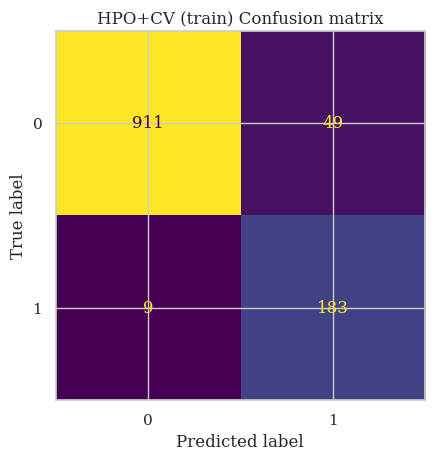

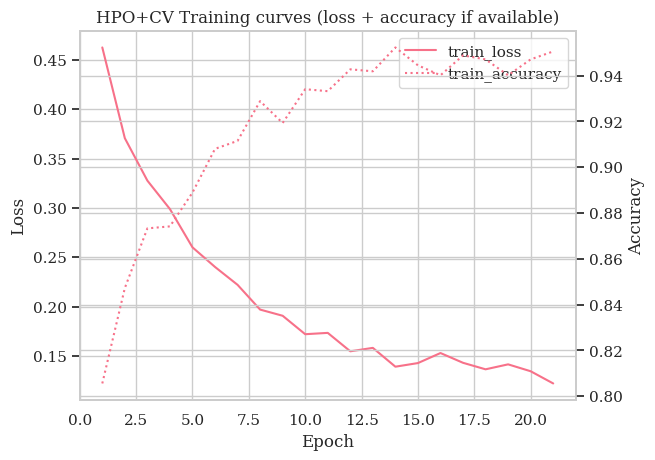

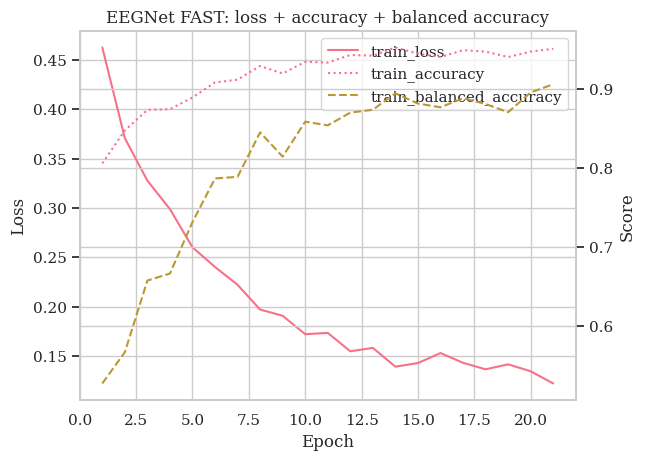

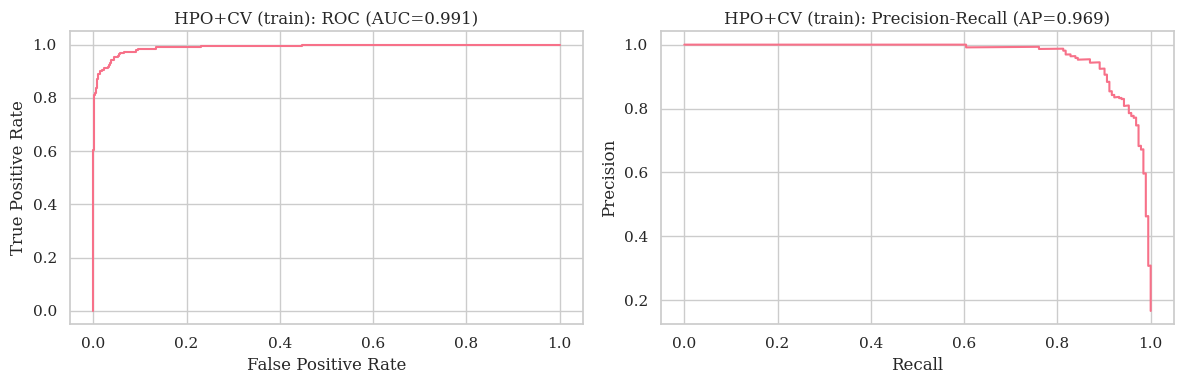

In [53]:
y_true_tr, y_proba_tr, y_pred_tr = _get_proba_and_pred(final_clf_eegnet, train_set)

print_basic_metrics(y_true_tr, y_proba_tr, y_pred_tr, header="HPO+CV (train)")

plot_confmat(
    y_true_tr,
    y_pred_tr,
    title="HPO+CV (train) Confusion matrix",
    normalize=None
)

plot_history_loss_and_accuracy(
    final_clf_eegnet,
    title="HPO+CV Training curves (loss + accuracy if available)"
)

plot_history_loss_acc_bacc(
    final_clf_eegnet, title="EEGNet FAST: loss + accuracy + balanced accuracy"
)

plot_roc_and_pr(
    y_true_tr,
    y_proba_tr,
    title_prefix="HPO+CV (train)"
)


Test plots

HPO+CV (test)
  accuracy:          0.8993
  balanced_accuracy: 0.8604
  roc_auc:           0.9227
  avg_precision:     0.7879


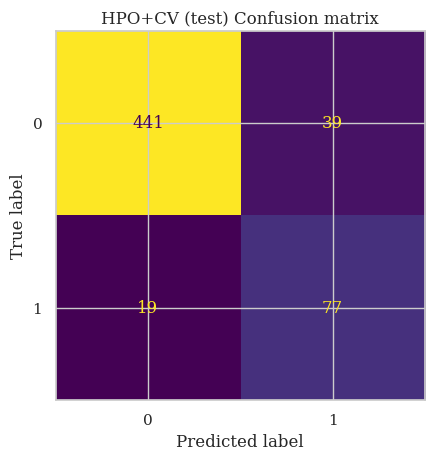

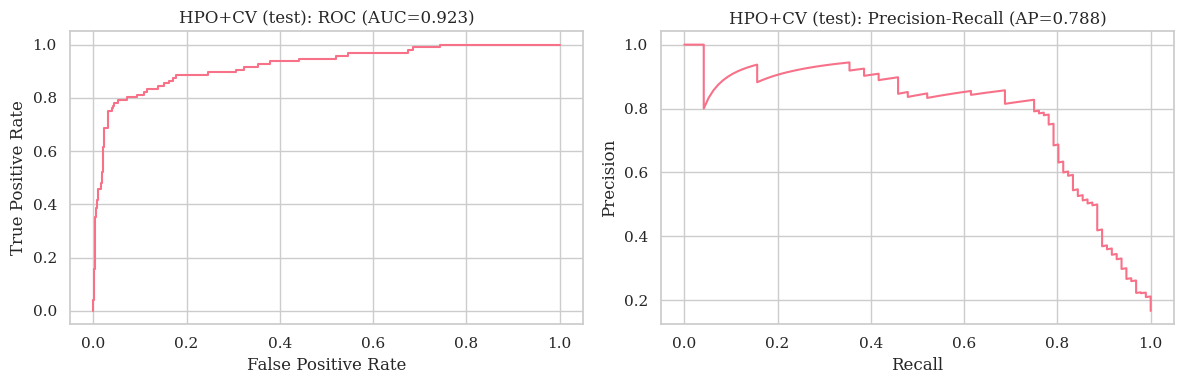

In [54]:
y_true_te, y_proba_te, y_pred_te = _get_proba_and_pred(final_clf_eegnet, test_set)

print_basic_metrics(y_true_te, y_proba_te, y_pred_te, header="HPO+CV (test)")

plot_confmat(
    y_true_te,
    y_pred_te,
    title="HPO+CV (test) Confusion matrix",
    normalize=None
)

plot_roc_and_pr(
    y_true_te,
    y_proba_te,
    title_prefix="HPO+CV (test)"
)


# Fine-tuning

## ShallowFBCSNet

### HPO results

In [ ]:
lr = 0.0006697844425596637
max_epochs = 80
batch_size = 80
weight_decay = 0.0003374623018539655
patience = 13
drop_prob = 0.2153401882629321
n_filters_time = 40
filter_time_length = 97
n_filters_spat = 32
pool_time_length = 50
pool_time_stride = pool_time_length // 2

### Create split inside the held out participant

- Use session 1 and 2 for adaptation and session 3 for testing

In [ ]:
from torch.utils.data import Subset

meta_test = test_set.get_metadata().reset_index(drop=True)

# Identify the held-out subject id in test_set (should be 1 unique subject)
heldout_subjects = meta_test["subject"].unique()
HELDOUT_SUBJECT = int(heldout_subjects[0])
print("HELDOUT_SUBJECT =", HELDOUT_SUBJECT)

# Pick sessions for adaptation vs evaluation
sessions_sorted = sorted(meta_test["session"].unique())
print("sessions_sorted:", sessions_sorted)

# Default: first two sessions adapt, last session test
adapt_sessions = sessions_sorted[:-1]
test_sessions  = [sessions_sorted[-1]]

adapt_idx = meta_test.index[meta_test["session"].isin(adapt_sessions)].to_numpy()
subjtest_idx = meta_test.index[meta_test["session"].isin(test_sessions)].to_numpy()

adapt_pool_ds = Subset(test_set, adapt_idx)
subject_test_ds = Subset(test_set, subjtest_idx)

print("Adapt pool windows:", len(adapt_pool_ds))
print("Subject test windows:", len(subject_test_ds))

# Labels for these subsets (pull from metadata to avoid iterating)
y_adapt = meta_test.loc[adapt_idx, "target"].to_numpy().astype(int)
y_subjtest = meta_test.loc[subjtest_idx, "target"].to_numpy().astype(int)

print("Adapt label counts:", {k: int(v) for k, v in zip(*np.unique(y_adapt, return_counts=True))})
print("Test  label counts:", {k: int(v) for k, v in zip(*np.unique(y_subjtest, return_counts=True))})

HELDOUT_SUBJECT = 10
sessions_sorted: ['0', '1', '2']
Adapt pool windows: 1152
Subject test windows: 576
Adapt label counts: {0: 960, 1: 192}
Test  label counts: {0: 480, 1: 96}


### Subsamble the adaptation pool by percentage (stratified)

- this keeps the target and non-target balance roughly stable while you vary "how much data" is added
- Randomly taking 5% or 10% of windows can end up in being a lot of non-targets
    - all_indices: array of indices (relative to adapt_pool_ds / meta_test after filtering)
    - y: labels aligned with all_indices
    - frac: float in (0, 1]
    - rng: np.random.RandomState


In [15]:
def stratified_subsample_indices(all_indices, y, frac, rng):
    if not (0 < frac <= 1.0):
        raise ValueError("frac must be in (0, 1].")

    chosen = []
    for cls in np.unique(y):
        cls_mask = (y == cls)
        cls_idx = all_indices[cls_mask]
        n_take = max(1, int(np.ceil(frac * len(cls_idx))))
        # sample without replacement
        take = rng.choice(cls_idx, size=min(n_take, len(cls_idx)), replace=False)
        chosen.append(take)

    chosen = np.concatenate(chosen)
    rng.shuffle(chosen)
    return chosen

### Metric function

In [17]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score, average_precision_score

def eval_clf_on_dataset(clf, ds, y_true):
    proba = clf.predict_proba(ds)
    y_pred = np.argmax(proba, axis=1)

    out = {
        "acc": float(accuracy_score(y_true, y_pred)),
        "bacc": float(balanced_accuracy_score(y_true, y_pred)),
    }

    # Only meaningful for binary P300
    if len(np.unique(y_true)) == 2:
        out["auc"] = float(roc_auc_score(y_true, proba[:, 1]))
        out["ap"]  = float(average_precision_score(y_true, proba[:, 1]))
    else:
        out["auc"] = np.nan
        out["ap"]  = np.nan

    return out

### Build ShallowFBCSPNet

In [18]:
import torch
import numpy as np

from braindecode.models import ShallowFBCSPNet
from braindecode import EEGClassifier
from braindecode.util import set_random_seeds

from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.helper import predefined_split

from sklearn.metrics import balanced_accuracy_score, make_scorer

# Callbacks (balanced accuracy)
train_bacc_cb = EpochScoring(
    scoring=make_scorer(balanced_accuracy_score),
    on_train=True,
    name="train_bacc",
    lower_is_better=False,
)

valid_bacc_cb = EpochScoring(
    scoring=make_scorer(balanced_accuracy_score),
    on_train=False,
    name="valid_bacc",
    lower_is_better=False,
)

def make_shallow_clf_from_hpo_values(
    n_chans,
    n_times,
    n_classes,
    device,
    # saved HPO values
    lr,
    max_epochs,
    batch_size,
    weight_decay,
    patience,
    drop_prob,
    n_filters_time,
    filter_time_length,
    n_filters_spat,
    pool_time_length,
    pool_time_stride,
    # optional : early-stopping validation set
    valid_ds=None,
):
    """
    Build a fresh ShallowFBCSPNet + EEGClassifier using explicit hyperparameters.
    If valid_ds is provided, predefined_split(valid_ds) is used for early stopping.
    """

    model = ShallowFBCSPNet(
        n_chans=n_chans,
        n_outputs=n_classes,
        n_times=n_times,
        final_conv_length="auto",
        n_filters_time=n_filters_time,
        filter_time_length=filter_time_length,
        drop_prob=drop_prob,
        n_filters_spat=n_filters_spat,
        pool_time_length=pool_time_length,
        pool_time_stride=pool_time_stride,
    ).to(device)

    clf = EEGClassifier(
        model,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        max_epochs=max_epochs,
        device=device,
        iterator_train__shuffle=True,
        train_split=(predefined_split(valid_ds) if valid_ds is not None else None),
        classes=list(range(n_classes)),
        callbacks=[
            ("train_bacc", train_bacc_cb),
            ("valid_bacc", valid_bacc_cb),
            ("early_stopping", EarlyStopping(
                monitor="valid_loss",
                patience=patience,
                lower_is_better=True,
                threshold=1e-4,
                threshold_mode="rel",
                load_best=True,
            )),
        ],
    )
    return clf

### Train general model and save weights

In [ ]:
# Reproducibility
set_random_seeds(seed=2026, cuda=cuda)

# Build a fresh general model with your HPO hyperparameters
general_shallow_clf = make_shallow_clf_from_hpo_values(
    n_chans=n_chans,
    n_times=n_times,
    n_classes=n_classes,
    device=device,
    lr=lr,
    max_epochs=max_epochs,
    batch_size=batch_size,
    weight_decay=weight_decay,
    patience=patience,              # early stopping patience (only used if valid_ds is provided)
    drop_prob=drop_prob,
    n_filters_time=n_filters_time,
    filter_time_length=filter_time_length,
    n_filters_spat=n_filters_spat,
    pool_time_length=pool_time_length,
    pool_time_stride=pool_time_stride,
    valid_ds=None,                  # no early stopping for full retrain (recommended baseline)
)

# Train on all cross-subject training data (subjects 1–9)
general_shallow_clf.fit(train_set, y=None)

# Save weights so every personalization run starts from identical general parameters
general_state_dict_shallow = {k: v.detach().cpu().clone() for k, v in general_shallow_clf.module_.state_dict().items()}

print("General model trained. Saved general_state_dict with", len(general_state_dict_shallow), "tensors.")

# Baseline evaluation on the held-out subject test session
baseline = eval_clf_on_dataset(general_shallow_clf, subject_test_ds, y_subjtest)
print("Baseline (no personalization) on held-out subject test session:", baseline)

### Fine-tune with increasing fractions

- Learning curve to see how much subject data is enough before gains saturate.
- Doing a full fine-tuning
    - every personalisation run starts from exactly the same cross-subject solution


In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data import Subset

# Fractions of the held-out subject adaptation pool to try
fractions = [0.01, 0.02, 0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 1.00]

# Fine-tuning settings (do not overwrite your baseline HPO vars)
ft_lr = lr * 0.1                 # smaller LR for subject-specific tuning
ft_max_epochs = 25               # fewer epochs for adaptation
ft_patience = min(patience, 6)   # quicker early stopping
inner_valid_frac = 0.20          # early-stopping split inside adaptation subset

# Reproducible sampling
rng_master = np.random.RandomState(2026)

# Indices relative to adapt_pool_ds
adapt_pool_indices = np.arange(len(adapt_pool_ds))

results = []

for frac in fractions:
    # reproducible sampling per fraction
    rng = np.random.RandomState(rng_master.randint(0, 10**9))

    # stratified sample from adaptation pool (keeps class ratio roughly stable)
    chosen_idx_rel = stratified_subsample_indices(
        all_indices=adapt_pool_indices,
        y=y_adapt,
        frac=frac,
        rng=rng,
    )

    chosen_ds = Subset(adapt_pool_ds, chosen_idx_rel)

    # inner split for early stopping
    n = len(chosen_idx_rel)
    perm = rng.permutation(n)
    n_valid = max(1, int(np.ceil(inner_valid_frac * n)))

    valid_rel = perm[:n_valid]
    train_rel = perm[n_valid:]

    ft_train_ds = Subset(chosen_ds, train_rel)
    ft_valid_ds = Subset(chosen_ds, valid_rel)

    # Build a fresh fine-tune classifier with your function
    set_random_seeds(seed=2026, cuda=cuda)

    ft_shallow_clf = make_shallow_clf_from_hpo_values(
        n_chans=n_chans,
        n_times=n_times,
        n_classes=n_classes,
        device=device,
        lr=ft_lr,
        max_epochs=ft_max_epochs,
        batch_size=batch_size,
        weight_decay=weight_decay,
        patience=ft_patience,
        drop_prob=drop_prob,
        n_filters_time=n_filters_time,
        filter_time_length=filter_time_length,
        n_filters_spat=n_filters_spat,
        pool_time_length=pool_time_length,
        pool_time_stride=pool_time_stride,
        valid_ds=ft_valid_ds,   # enables early stopping via predefined_split
    )

    # initialize first, then load the general weights
    ft_shallow_clf.initialize()
    ft_shallow_clf.module_.load_state_dict(general_state_dict_shallow)

    # Fine-tune
    ft_shallow_clf.fit(ft_train_ds, y=None)

    # Evaluate on the fixed held-out session test split
    metrics = eval_clf_on_dataset(ft_shallow_clf, subject_test_ds, y_subjtest)

    row = {
        "frac": frac,
        "n_adapt": len(chosen_ds),
        **metrics,
    }
    results.append(row)

    print(
        f"frac={frac:>4} | n_adapt={len(chosen_ds):>4} | "
        f"bacc={row['bacc']:.3f} | acc={row['acc']:.3f} | "
        f"auc={row['auc'] if not np.isnan(row['auc']) else 'nan'} | "
        f"ap={row['ap'] if not np.isnan(row['ap']) else 'nan'}"
    )

df_results = pd.DataFrame(results)
df_results

### Plot personalisation learning curve

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_results["n_adapt"], df_results["bacc"], marker="o")
plt.axhline(baseline["bacc"], linestyle="--", label="Baseline (no personalization)")
plt.xlabel("Number of adaptation windows")
plt.ylabel("Balanced accuracy on held-out session")
plt.title("Subject-specific fine-tuning: learning curve (ShallowFBCSPNet)")
plt.legend()
plt.show()

## EEGNet